In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from math import sqrt
import pandas as pd
import os
import re
import numpy as np
import pickle

In [10]:
#import data
total_data2024 = pd.read_excel("../data/raw/all_alpha_24.xlsx")
total_data2023 = pd.read_excel("../data/raw/all_alpha_23.xlsx")
total_data2022 = pd.read_excel("../data/raw/all_alpha_22.xlsx")
total_data2021 = pd.read_excel("../data/raw/all_alpha_21.xlsx")
total_data2020 = pd.read_excel("../data/raw/all_alpha_20.xlsx")
total_data2019 = pd.read_excel("../data/raw/all_alpha_19.xlsx")
total_data2018 = pd.read_excel("../data/raw/all_alpha_18.xlsx")
total_data2017 = pd.read_excel("../data/raw/all_alpha_17.xlsx")
total_data2016 = pd.read_excel("../data/raw/all_alpha_16.xlsx")
total_data2015 = pd.read_excel("../data/raw/all_alpha_15.xlsx")
total_data2014 = pd.read_excel("../data/raw/all_alpha_14.xlsx")
total_data2013 = pd.read_excel("../data/raw/all_alpha_13.xlsx")
total_data2012 = pd.read_excel("../data/raw/all_alpha_12.xlsx")
total_data2011 = pd.read_excel("../data/raw/all_alpha_11.xlsx")
total_data2010 = pd.read_excel("../data/raw/all_alpha_10.xls")
total_data2009 = pd.read_excel("../data/raw/all_alpha_09.xls")
total_data2008 = pd.read_excel("../data/raw/all_alpha_08.xls")
total_data2007 = pd.read_excel("../data/raw/all_alpha_07.xls")
total_data2006 = pd.read_excel("../data/raw/all_alpha_06.xls")
total_data2005 = pd.read_excel("../data/raw/all_alpha_05.xls")
total_data2004 = pd.read_excel("../data/raw/all_alpha_04.xls")
total_data2003 = pd.read_excel("../data/raw/all_alpha_03.xls")
total_data2002 = pd.read_excel("../data/raw/all_alpha_02.xls")
total_data2001 = pd.read_excel("../data/raw/all_alpha_01.xls")
total_data2000 = pd.read_excel("../data/raw/all_alpha_00 (1).xls")


In [11]:
#Add year to each data set as a column

total_data2024['Year'] = 2024
total_data2023['Year'] = 2023
total_data2022['Year'] = 2022
total_data2021['Year'] = 2021
total_data2020['Year'] = 2020
total_data2019['Year'] = 2019
total_data2018['Year'] = 2018
total_data2017['Year'] = 2017
total_data2016['Year'] = 2016
total_data2015['Year'] = 2015
total_data2014['Year'] = 2014
total_data2013['Year'] = 2013
total_data2012['Year'] = 2012
total_data2011['Year'] = 2011
total_data2010['Year'] = 2010
total_data2009['Year'] = 2009
total_data2008['Year'] = 2008
total_data2007['Year'] = 2007
total_data2006['Year'] = 2006
total_data2005['Year'] = 2005
total_data2004['Year'] = 2004
total_data2003['Year'] = 2003
total_data2002['Year'] = 2002
total_data2001['Year'] = 2001
total_data2000['Year'] = 2000

In [12]:
#merge all datasets into one
merged_data = pd.concat([total_data2024, total_data2023, total_data2022, total_data2021, total_data2020, 
                         total_data2019, total_data2018, total_data2017, total_data2016, total_data2015, 
                         total_data2014, total_data2013, total_data2012, total_data2011, total_data2010, 
                         total_data2009, total_data2008, total_data2007, total_data2006, total_data2005, 
                         total_data2004, total_data2003, total_data2002, total_data2001, total_data2000], ignore_index=True)

In [13]:
# Drop rows containing 'N/A*'
merged_data = merged_data[~merged_data['City MPG'].astype(str).str.contains('N/A*')]

In [14]:
# Drop rows containing 'nan'
merged_data = merged_data[~merged_data['City MPG'].astype(str).str.contains('nan')]

In [15]:
# Convert "Air Pollution Score" column to string type
merged_data["Air Pollution Score"] = merged_data["Air Pollution Score"].astype(str)

In [16]:
#one row has Gasoline/Electricity and its values flipped (Ie 90/35 instead of 35/90), 
#this fixes that for the 'Fuel', 'City MPG', "Hwy MPG', and 'Cmb MPG'
def reverse_mpg_values(df):
    # Filter rows where Fuel is 'Electricity/Gasoline'
    filter_condition = df['Fuel'] == 'Electricity/Gasoline'
    filtered_df = df[filter_condition].copy()

    # Change 'Electricity/Gasoline' to 'Gasoline/Electricity'
    filtered_df.loc[:, 'Fuel'] = 'Gasoline/Electricity'

    # Check if columns exist before splitting
    if 'City MPG' in filtered_df.columns:
        # Reverse the 'City MPG' values
        filtered_df[['Gasoline_City_MPG', 'Electricity_City_MPG']] = filtered_df['City MPG'].str.split('/', expand=True)
        filtered_df['City MPG'] = filtered_df['Electricity_City_MPG'] + '/' + filtered_df['Gasoline_City_MPG']

    if 'Hwy MPG' in filtered_df.columns:
        # Reverse the 'Hwy MPG' values
        filtered_df[['Gasoline_Hwy_MPG', 'Electricity_Hwy_MPG']] = filtered_df['Hwy MPG'].str.split('/', expand=True)
        filtered_df['Hwy MPG'] = filtered_df['Electricity_Hwy_MPG'] + '/' + filtered_df['Gasoline_Hwy_MPG']

    if 'Cmb MPG' in filtered_df.columns:
        # Reverse the 'Cmb MPG' values
        filtered_df[['Gasoline_Cmb_MPG', 'Electricity_Cmb_MPG']] = filtered_df['Cmb MPG'].str.split('/', expand=True)
        filtered_df['Cmb MPG'] = filtered_df['Electricity_Cmb_MPG'] + '/' + filtered_df['Gasoline_Cmb_MPG']

    # Drop unnecessary columns
    columns_to_drop = ['Gasoline_City_MPG', 'Electricity_City_MPG', 'Gasoline_Hwy_MPG', 'Electricity_Hwy_MPG', 
                       'Gasoline_Cmb_MPG', 'Electricity_Cmb_MPG']
    filtered_df.drop(columns_to_drop, axis=1, inplace=True, errors='ignore')

    # Update the original DataFrame with the modified values
    df.update(filtered_df)

    return df

# Call the function on your merged_data DataFrame
merged_data = reverse_mpg_values(merged_data)

In [17]:
#Fix names in 'Fuel' column to conform to a naming convention
merged_data['Fuel'] = merged_data['Fuel'].replace('Gasoline/Electricty', 'Gasoline/Electricity')
merged_data['Fuel'] = merged_data['Fuel'].replace('ethanol', 'Ethanol')
merged_data['Fuel'] = merged_data['Fuel'].replace('diesel', 'Diesel')
merged_data['Fuel'] = merged_data['Fuel'].replace('ethanol/gas', 'Ethanol/Gas')
merged_data['Fuel'] = merged_data['Fuel'].replace('Ethanol/Gas', 'Ethanol/Gasoline')
merged_data['Fuel'] = merged_data['Fuel'].replace('CNG/gas', 'CNG/Gasoline')

In [18]:
#drop duplicates, ignoring the specified columns
merged_data.drop_duplicates(subset=merged_data.columns.difference(['Cert Region', 'Stnd', 'Stnd Description', 'Sales Area']), inplace=True)

In [19]:
#split MODEL column into CAR_MAKE and CAR_MODEL

def split_model(row):
    if 'ASTON MARTIN' in row['Model']:
        return 'ASTON MARTIN', row['Model'].replace('ASTON MARTIN ', '')
    elif 'LAND ROVER' in row['Model']:
        return 'LAND ROVER', row['Model'].replace('LAND ROVER ', '')
    elif 'ALFA ROMEO' in row['Model']:
        return 'ALFA ROMEO', row['Model'].replace('ALFA ROMEO ', '')
    elif 'VEHICLE PRODUCTION GROUP' in row['Model']:
        return 'VEHICLE PRODUCTION GROUP', row['Model'].replace('VEHICLE PRODUCTION GROUP ', '')
    else:
        return row['Model'].split(maxsplit=1)
    
#apply function split_model
merged_data[['Car_Make', 'Car_Model']] = merged_data.apply(split_model, axis=1, result_type='expand')



In [20]:
#columns to remove before pipeline

columns_to_remove = ['Model', 
                     'Cert Region', 
                     'Comb CO2', 
                     'Stnd', 
                     'Stnd Description', 
                     'Underhood ID',  
                     'Sales Area', 
                     'FE Calc Appr', 
                     'Unadj Cmb MPG', 
                     'Comb CO2',
                     'SmartWay']

for column in columns_to_remove:
    try:
        merged_data = merged_data.drop(column, axis=1)
    except:
        print(f"Column {column} was already removed.")


Column Comb CO2 was already removed.


In [21]:
#for cylinders, since electric cars don't have cylinders, we replace the nan value with their fuel type of Electric
def handle_nan(row):
    if pd.isna(row['Cyl']):
        return row['Fuel']  # If NaN, copy value from 'Fuel' column
    else:
        return row['Cyl']  # Return the original value if not NaN

In [22]:
#fix naming conventions of cyl column
def convert_cyl(row):
    if row['Cyl'] == '(6 cyl)':
        return 6.0
    elif row['Cyl'] == '(4 cyl)':
        return 4.0
    elif row['Cyl'] == '(12 cyl)':
        return 12.0
    elif row['Cyl'] == '(8 cyl)':
        return 8.0
    elif row['Cyl'] == '(10 cyl)':
        return 10.0
    elif row['Cyl'] == '(16 cyl)':
        return 16.0
    elif row['Cyl'] == '(5 cyl)':
        return 5.0
    elif row['Cyl'] == '(2 cyl)':
        return 2.0
    elif row['Cyl'] == '(3 cyl)':
        return 3.0
    else:
        return row['Cyl']
    
merged_data['Cyl'] = merged_data.apply(convert_cyl, axis=1)

In [23]:
def calculate_average(value):
    if pd.isna(value):  # Check if value is NaN
        return np.nan  # Return NaN if value is NaN
    if isinstance(value, str) and '/' in value:
        nums = [float(num) for num in value.split('/') if num.isdigit()]
        if len(nums) == 0:
            return np.nan  # Return NaN if no numeric values are found
        return sum(nums) / len(nums)
    elif isinstance(value, int) or isinstance(value, float):
        return float(value)  # Return value if it's already numeric
    else:
        return value  # Return NaN for non-numeric values

In [24]:
merged_data['Air Pollution Score'] = merged_data['Air Pollution Score'].apply(calculate_average)
merged_data['Greenhouse Gas Score'] = merged_data['Greenhouse Gas Score'].apply(calculate_average)


In [25]:
def split_fuel_records(df):
    new_rows = []
    for index, row in df.iterrows():
        fuel = row['Fuel']
        city_mpg = row['City MPG']

        # Initialize IsHybrid column with default value
        row['IsHybrid'] = 'Not Hybrid'

        # Update IsHybrid based on fuel type
        if fuel == 'Gasoline/Electricity':
            row['IsHybrid'] = 'Electric Hybrid'
        elif fuel == 'Ethanol/Gasoline':
            row['IsHybrid'] = 'Ethanol Hybrid'

        if ('/' in fuel) and ('/' in city_mpg):
            fuels = fuel.split('/')
            city_mpgs = city_mpg.split('/')
            for i, fuel_type in enumerate(fuels):
                new_row = row.copy()
                new_row['Fuel'] = fuel_type.strip()
                new_row['City MPG'] = city_mpgs[i].strip()
                new_rows.append(new_row)
        else:
            new_rows.append(row)
    return pd.DataFrame(new_rows)

In [26]:
merged_data = split_fuel_records(merged_data).reset_index(drop=True)

In [27]:
nan_count_per_column = {col: merged_data[col].astype(str).str.count('nan').sum() for col in merged_data.columns}

print("Count of occurrences of 'nan' in each column:")
for col, count in nan_count_per_column.items():
    print(f"{col}: {count}")

Count of occurrences of 'nan' in each column:
Displ: 803
Cyl: 807
Trans: 0
Drive: 0
Fuel: 0
Veh Class: 0
Air Pollution Score: 25
City MPG: 0
Hwy MPG: 0
Cmb MPG: 0
Greenhouse Gas Score: 0
Year: 0
Car_Make: 0
Car_Model: 11
IsHybrid: 0


In [28]:
na_count_per_column = {col: merged_data[col].astype(str).str.count('N/A*').sum() for col in merged_data.columns}

print("Count of occurrences of 'N/A*' in each column:")
for col, count in na_count_per_column.items():
    print(f"{col}: {count}")

Count of occurrences of 'N/A*' in each column:
Displ: 0
Cyl: 0
Trans: 0
Drive: 0
Fuel: 0
Veh Class: 0
Air Pollution Score: 0
City MPG: 0
Hwy MPG: 0
Cmb MPG: 0
Greenhouse Gas Score: 0
Year: 0
Car_Make: 0
Car_Model: 0
IsHybrid: 0


In [29]:
# Assuming merged_data is your DataFrame and 'Column_Name' is the column you want to convert to float
column_name = 'City MPG'

# Before converting, ensure there are no non-numeric values
# If the column has non-numeric values (like strings), you need to handle or clean them first

# Convert the column to float
merged_data[column_name] = merged_data[column_name].astype(float)

In [30]:
# def get_parent_company(car_make):
#     parent_company_mapping = {
#         'Ford': 'Ford',
#         'Lincoln': 'Ford',
#         'Genesis': 'Hyundai',
#         'Kia': 'Hyundai',
#         'Hyundai': 'Hyundai',
#         'Toyota': 'Toyota',
#         'Lexus': 'Toyota',
#         'Daihatsu': 'Toyota',
#         'Chevrolet': 'GM',
#         'Holden': 'GM',
#         'Vauxhall': 'GM',
#         'Cadillac': 'GM',
#         'Opel': 'GM',
#         'GMC': 'GM',
#         'GM': 'GM',
#         'Buick': 'GM',

#     }
#     return parent_company_mapping.get(car_make, "Unknown")

# # Test the function
# car_makes = ['Ford', 'Lincoln', 'Genesis', 'Kia', 'Hyundai', 'Toyota', 'Lexus', 'Daihatsu', 'Chevrolet', 'Holden', 'Vauxhall', 'Cadillac', 'Opel', 'GMC']
# for car_make in car_makes:
#     print(f"{car_make}: {get_parent_company(car_make)}")

In [31]:
#save cleaned data and merged data to CSV
merged_data.to_csv('../data/processed/merged_data.csv', index=False)

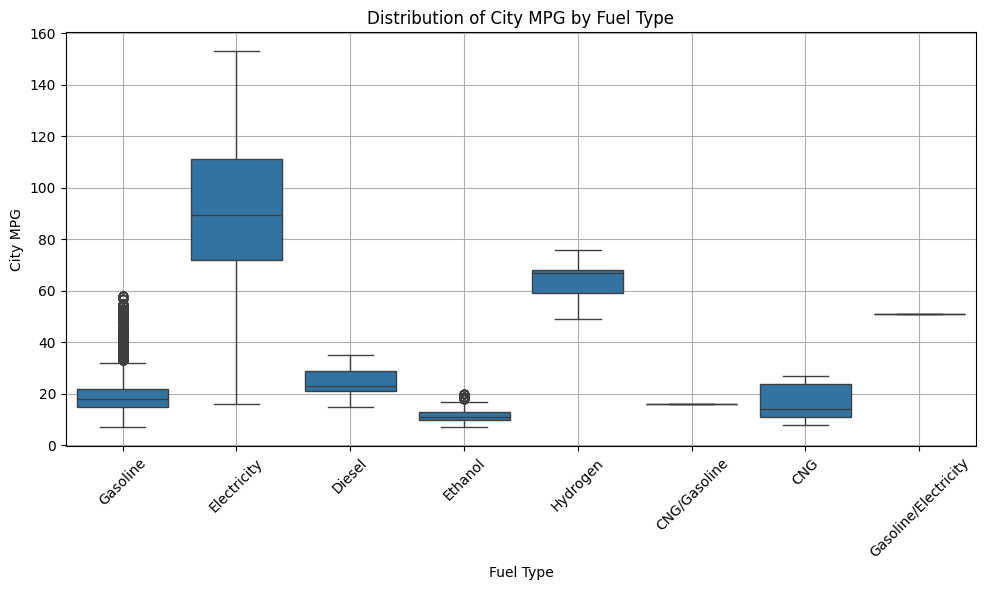

In [32]:
# Create the box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=merged_data, x='Fuel', y='City MPG')
plt.title('Distribution of City MPG by Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('City MPG')
plt.xticks(rotation=45)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

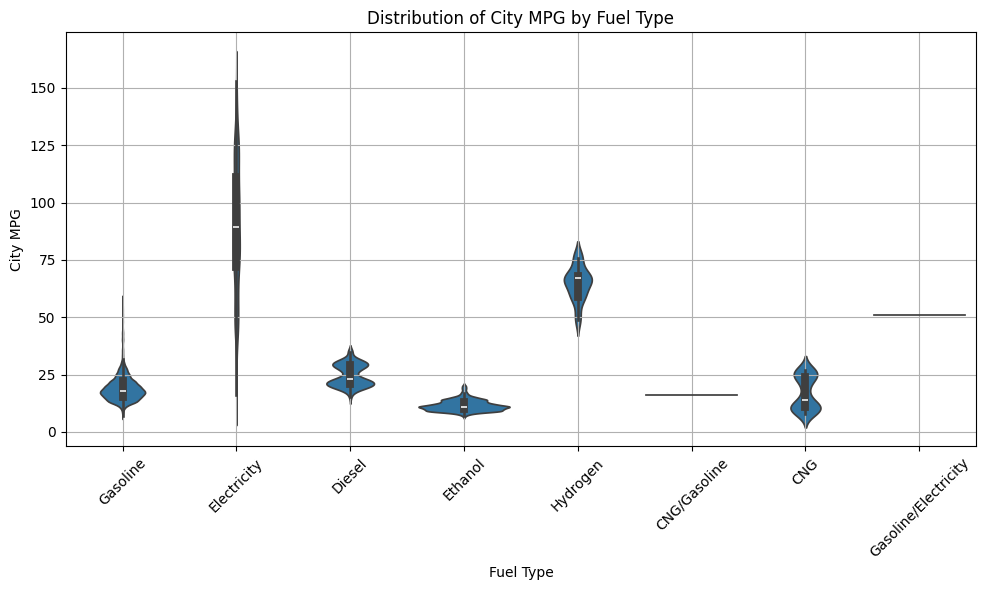

In [33]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=merged_data, x='Fuel', y='City MPG')
plt.title('Distribution of City MPG by Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('City MPG')
plt.xticks(rotation=45)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

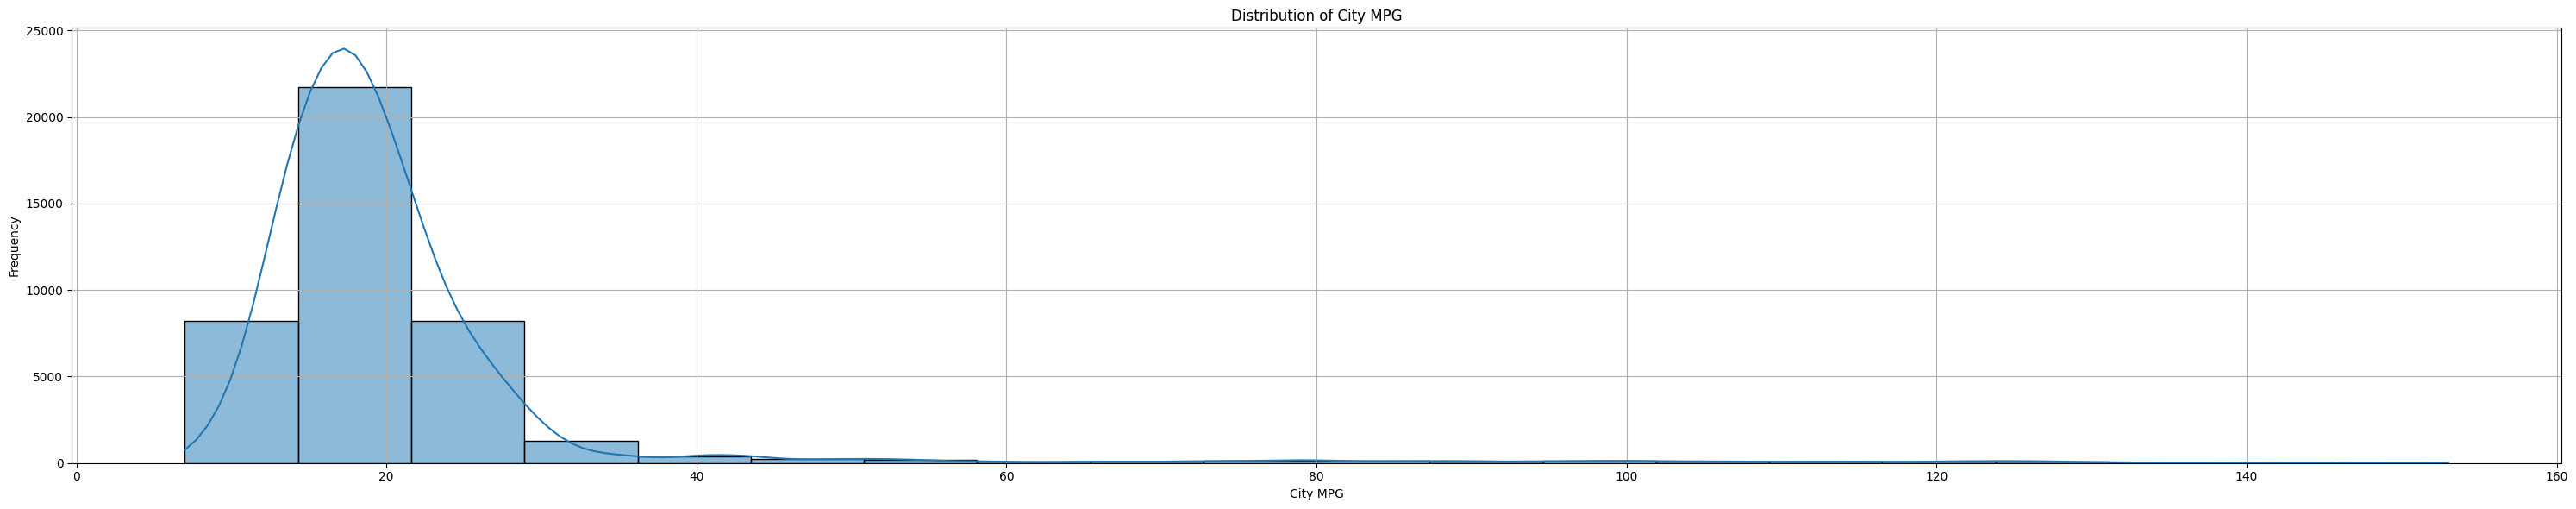

In [34]:
# Create the histogram
plt.figure(figsize=(30, 6))
sns.histplot(data=merged_data, x='City MPG', bins=20, kde=True)
plt.title('Distribution of City MPG')
plt.xlabel('City MPG')
plt.ylabel('Frequency')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

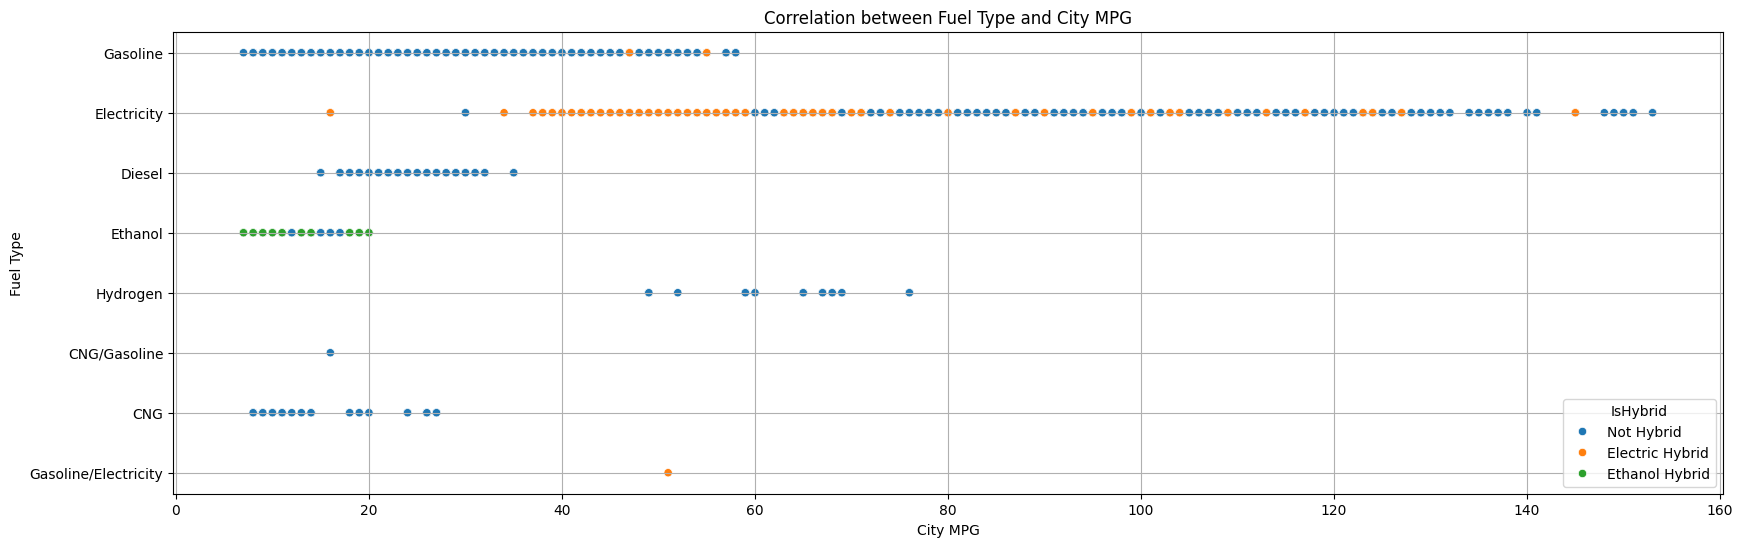

In [35]:

# Create the scatter plot
plt.figure(figsize=(20, 6))
sns.scatterplot(data=merged_data, x='City MPG', y='Fuel', hue='IsHybrid')
plt.title('Correlation between Fuel Type and City MPG')
plt.xlabel('City MPG')
plt.ylabel('Fuel Type')
plt.grid(True)

# Show the plot
plt.show()

In [36]:
# Filter the DataFrame
gasoline_electricity_rows = merged_data[merged_data['Fuel'] == 'Gasoline/Electricity']

# Print the filtered rows
print("Rows where Fuel is 'Gasoline/Electricity':")
print(gasoline_electricity_rows)

Rows where Fuel is 'Gasoline/Electricity':
       Displ  Cyl Trans Drive                  Fuel    Veh Class  \
20289    1.8  4.0   CVT   2WD  Gasoline/Electricity  midsize car   

      Air Pollution Score  City MPG Hwy MPG Cmb MPG Greenhouse Gas Score  \
20289                   9      51.0      49      50                   10   

       Year Car_Make             Car_Model         IsHybrid  
20289  2013   TOYOTA  Prius Plug-in Hybrid  Electric Hybrid  


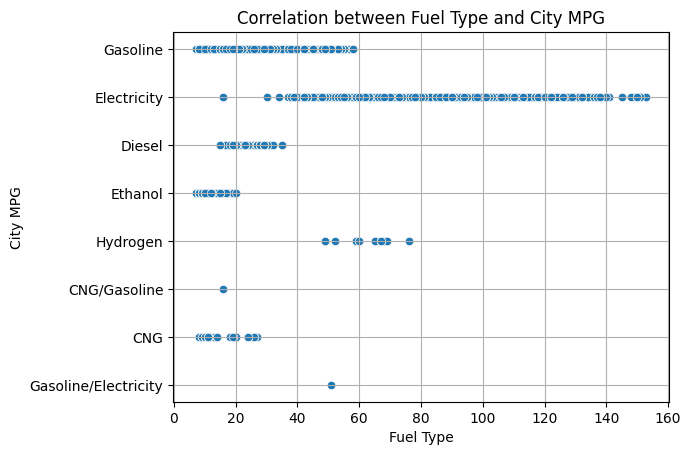

In [37]:
# Create the scatter plot
sns.scatterplot(data=merged_data, x='City MPG', y='Fuel')
plt.title('Correlation between Fuel Type and City MPG')
plt.xlabel('Fuel Type')
plt.ylabel('City MPG')
plt.grid(True)

# Show the plot
plt.show()

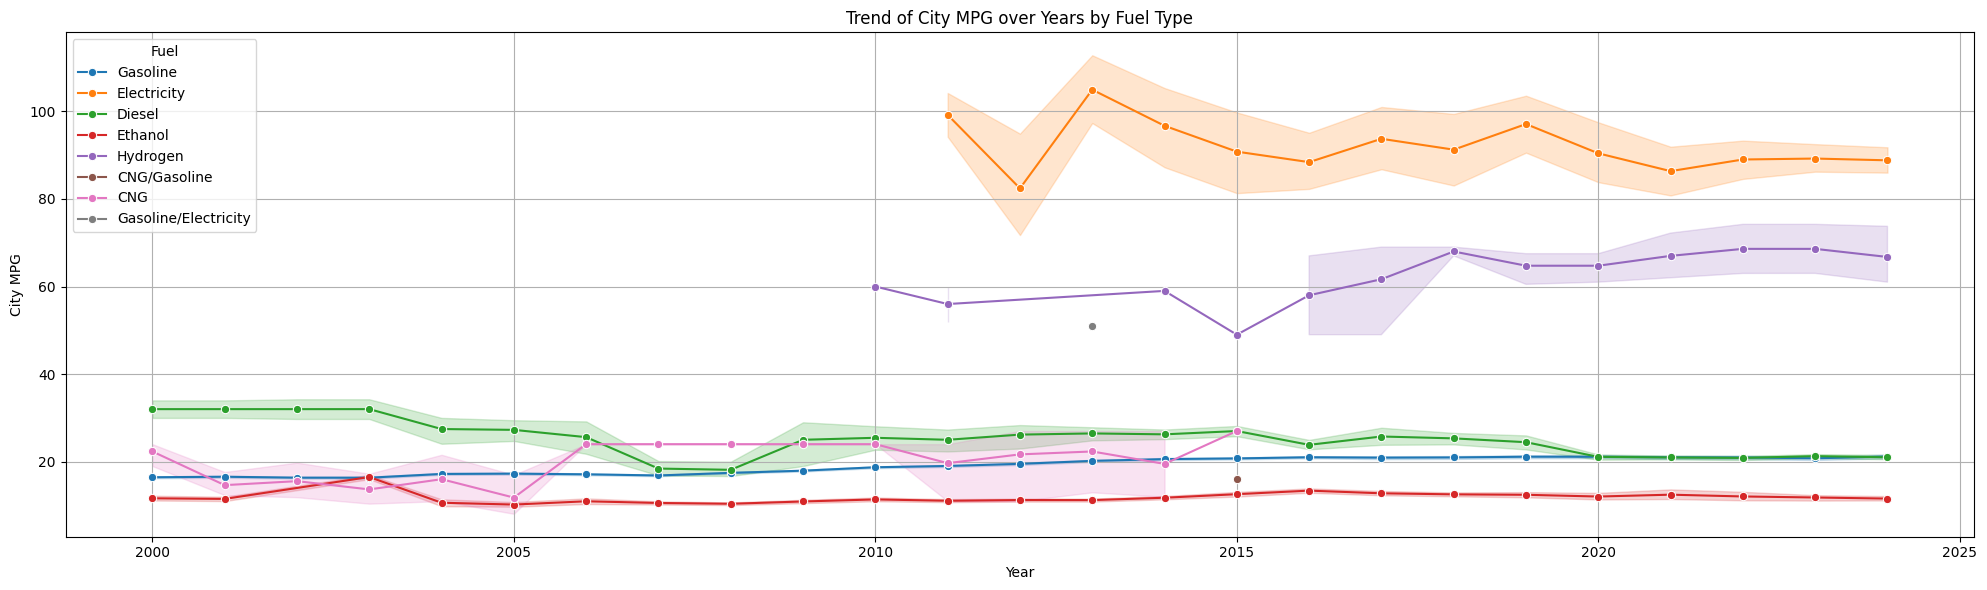

In [38]:
# Create the line plot
plt.figure(figsize=(20, 6))
sns.lineplot(data=merged_data, x='Year', y='City MPG', hue='Fuel', marker='o')
plt.title('Trend of City MPG over Years by Fuel Type')
plt.xlabel('Year')
plt.ylabel('City MPG')
plt.legend(title='Fuel')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

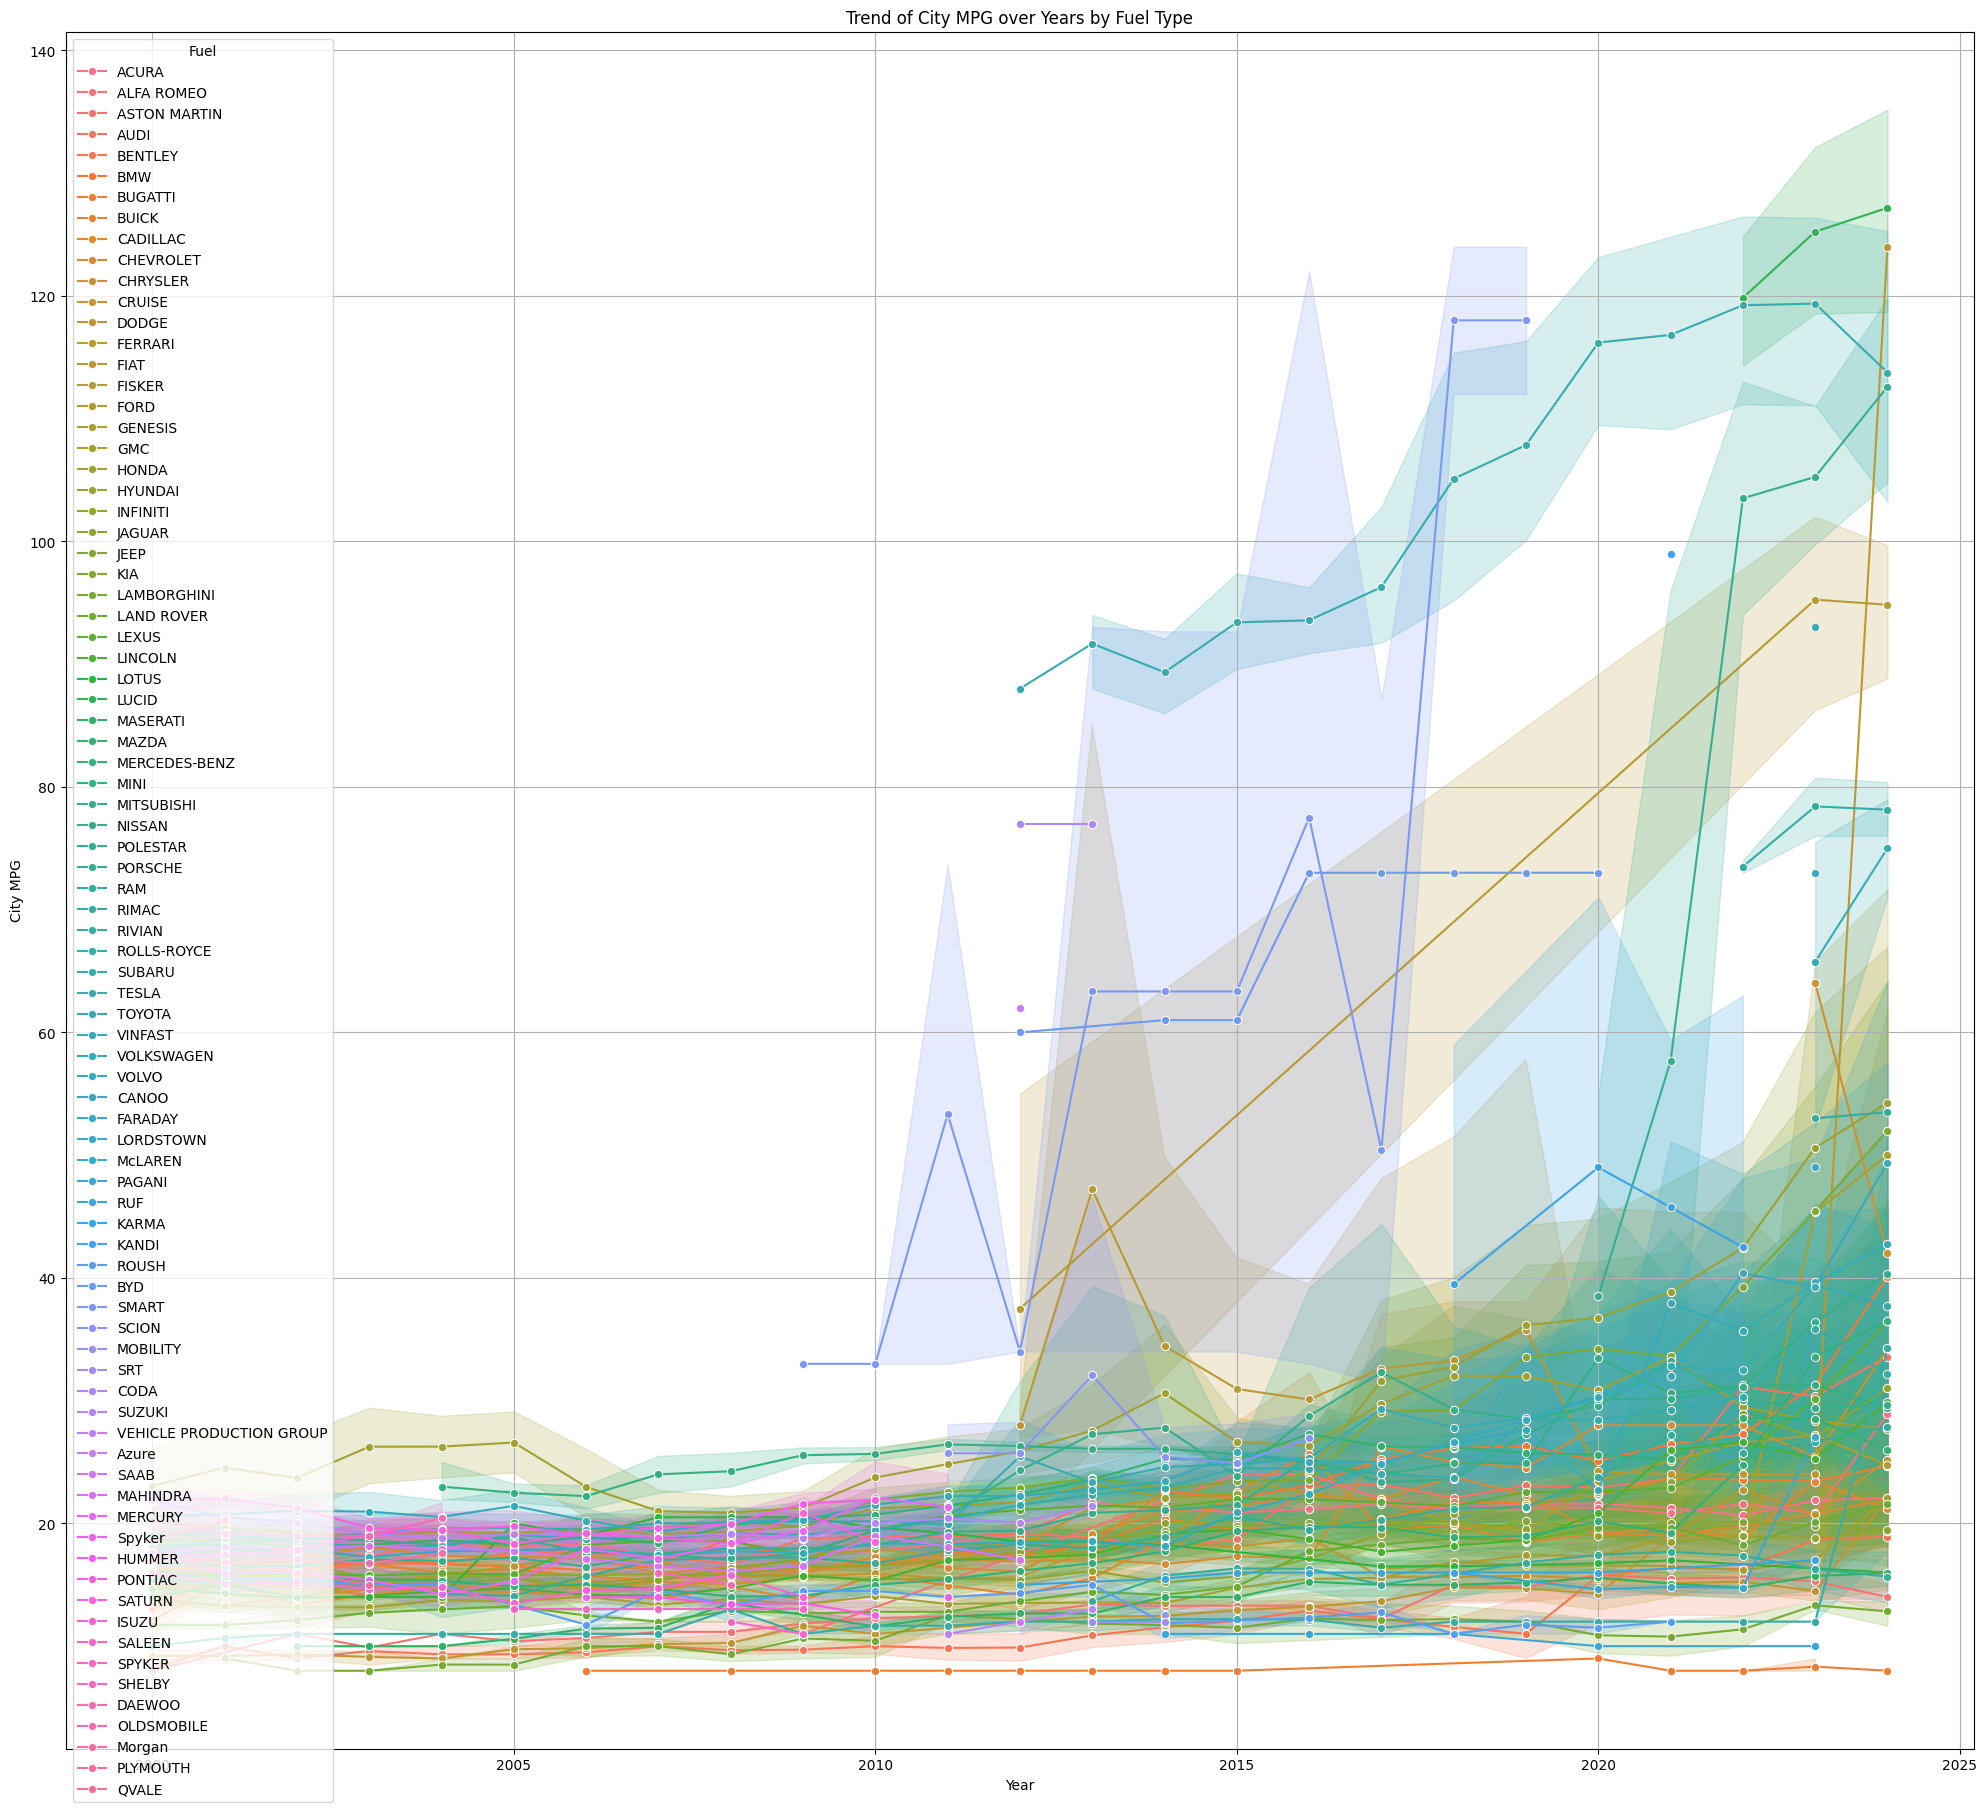

In [39]:
# Create the line plot
plt.figure(figsize=(20, 20))
sns.lineplot(data=merged_data, x='Year', y='City MPG', hue='Car_Make', marker='o')
plt.title('Trend of City MPG over Years by Fuel Type')
plt.xlabel('Year')
plt.ylabel('City MPG')
plt.legend(title='Fuel')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

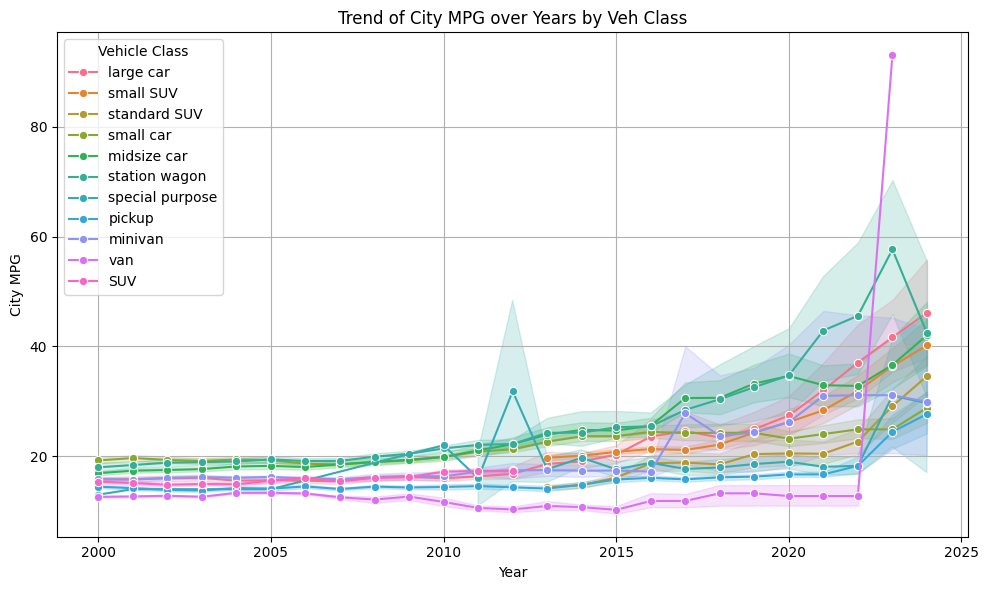

In [40]:
# Create the line plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=merged_data, x='Year', y='City MPG', hue='Veh Class', marker='o')
plt.title('Trend of City MPG over Years by Veh Class')
plt.xlabel('Year')
plt.ylabel('City MPG')
plt.legend(title='Vehicle Class')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

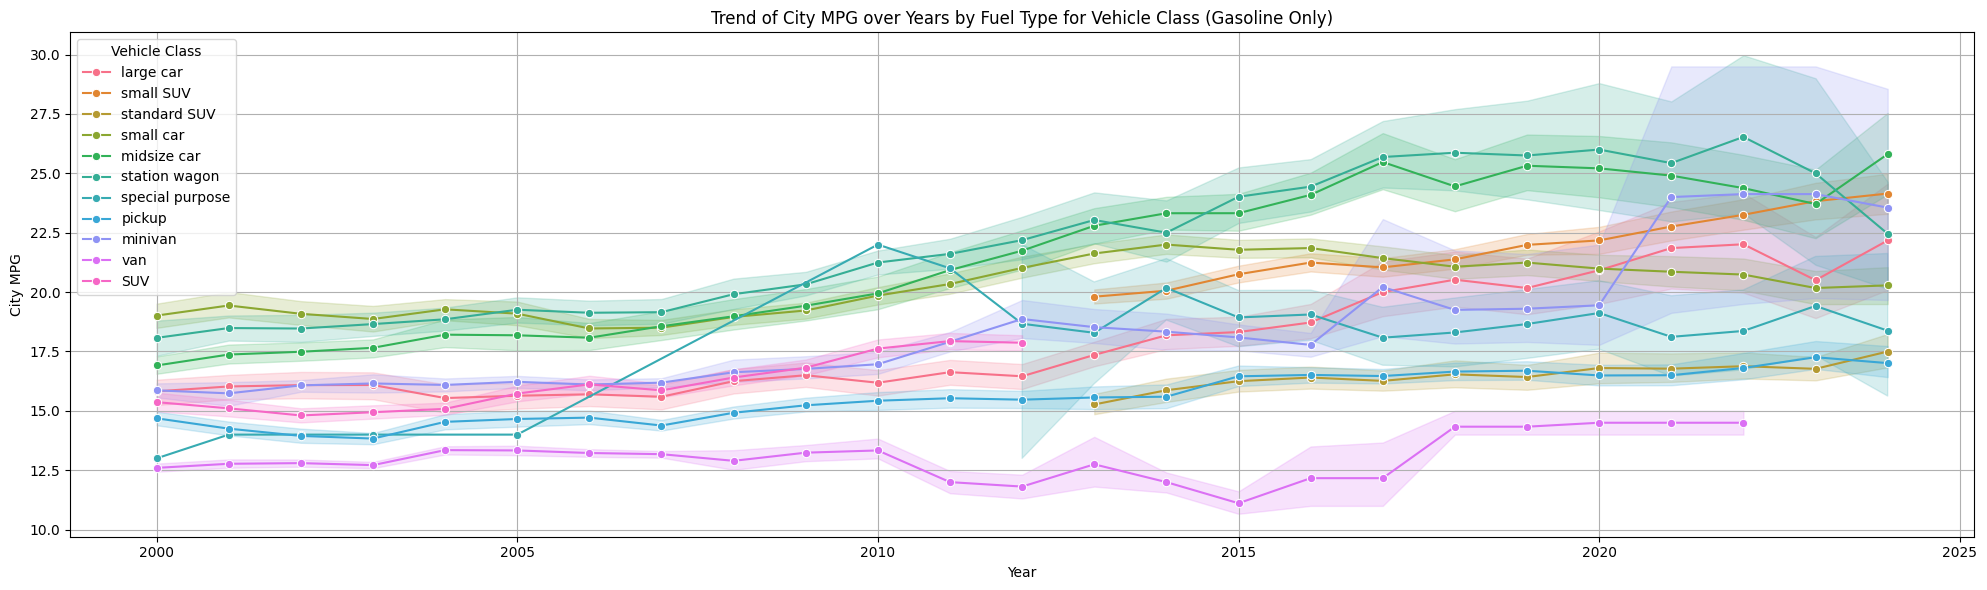

In [41]:
# Filter data for top 3 car makers and fuel type Gasoline

filtered_data = merged_data[(merged_data['Fuel'] == 'Gasoline')]

# Create the line plot
plt.figure(figsize=(20, 6))
sns.lineplot(data=filtered_data, x='Year', y='City MPG', hue='Veh Class', marker='o')
plt.title('Trend of City MPG over Years by Fuel Type for Vehicle Class (Gasoline Only)')
plt.xlabel('Year')
plt.ylabel('City MPG')
plt.legend(title='Vehicle Class')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

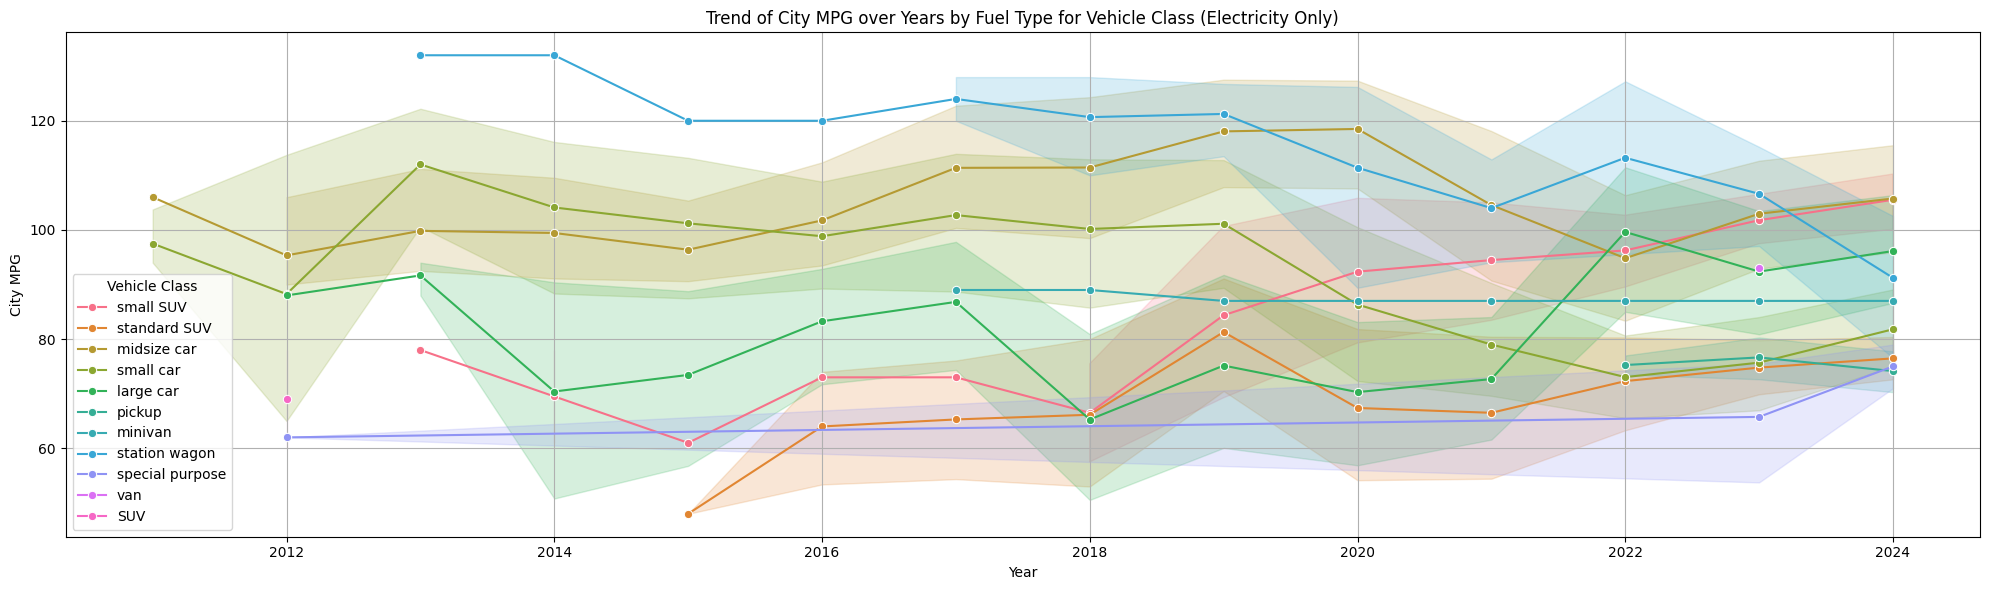

In [42]:
# Filter data for top 3 car makers and fuel type Gasoline

filtered_data = merged_data[(merged_data['Fuel'] == 'Electricity')]

# Create the line plot
plt.figure(figsize=(20, 6))
sns.lineplot(data=filtered_data, x='Year', y='City MPG', hue='Veh Class', marker='o')
plt.title('Trend of City MPG over Years by Fuel Type for Vehicle Class (Electricity Only)')
plt.xlabel('Year')
plt.ylabel('City MPG')
plt.legend(title='Vehicle Class')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

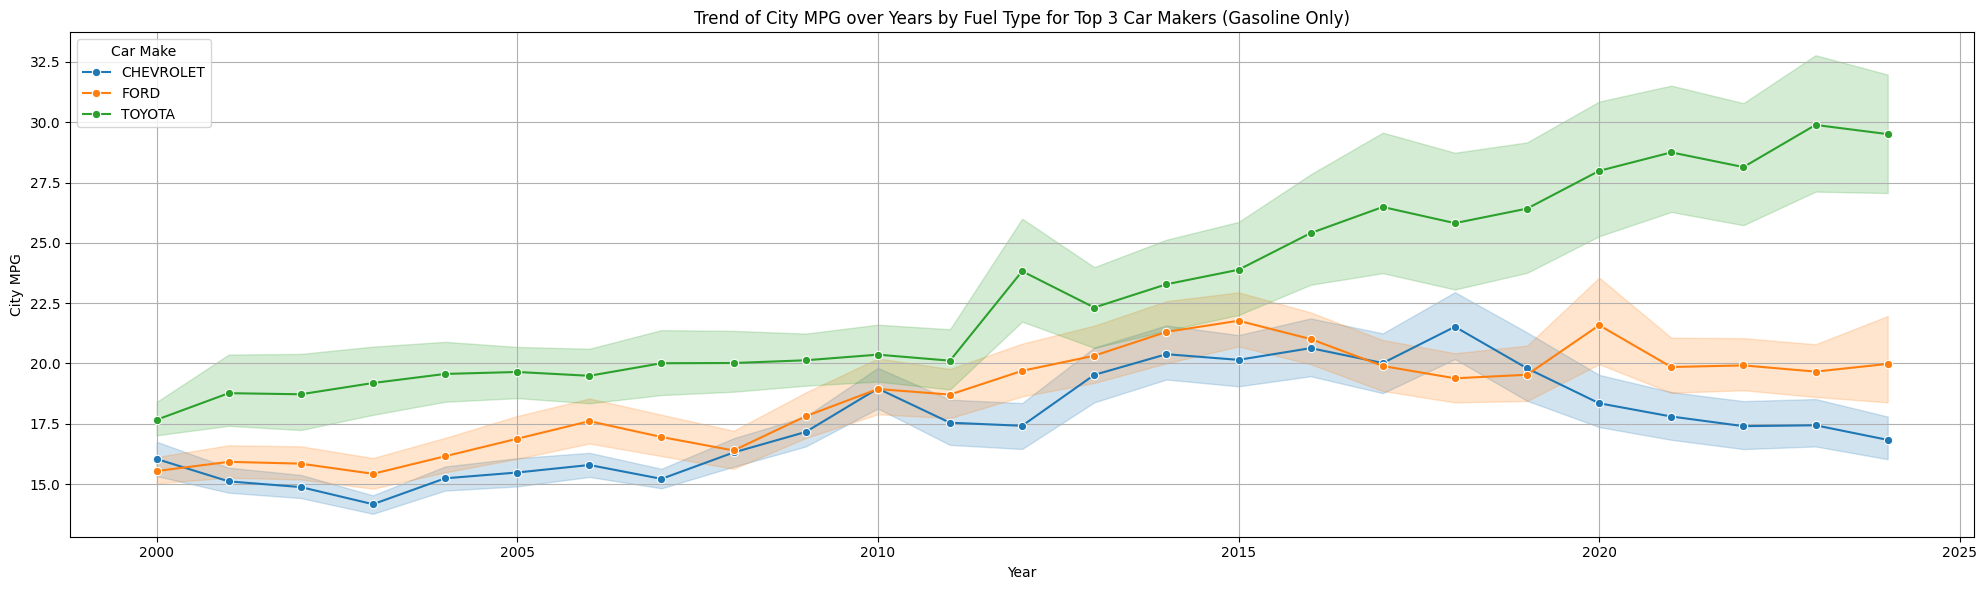

In [43]:
# Filter data for top 3 car makers and fuel type Gasoline
top_3_makers = ['FORD', 'TOYOTA', 'CHEVROLET']
filtered_data = merged_data[(merged_data['Car_Make'].isin(top_3_makers)) & (merged_data['Fuel'] == 'Gasoline')]

# Create the line plot
plt.figure(figsize=(20, 6))
sns.lineplot(data=filtered_data, x='Year', y='City MPG', hue='Car_Make', marker='o')
plt.title('Trend of City MPG over Years by Fuel Type for Top 3 Car Makers (Gasoline Only)')
plt.xlabel('Year')
plt.ylabel('City MPG')
plt.legend(title='Car Make')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

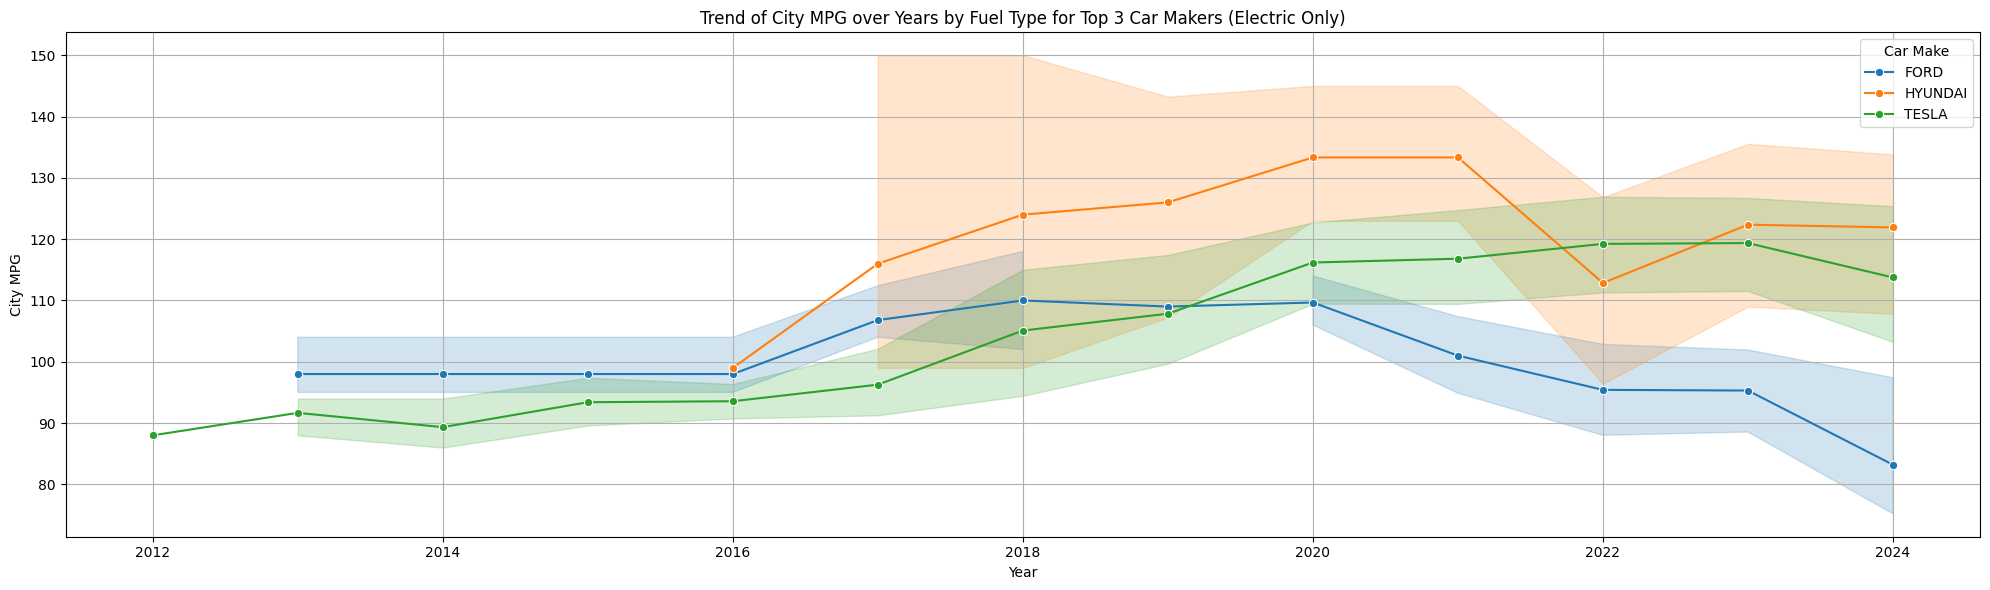

In [44]:
# Filter data for top 3 EV car makers and fuel type electricity
top_3_makers = ['TESLA', 'FORD', 'HYUNDAI'] #HYUNDAI NEED TO INCLUDE KIA AND GENESIS
filtered_data = merged_data[(merged_data['Car_Make'].isin(top_3_makers)) & (merged_data['Fuel'] == 'Electricity')]

# Create the line plot
plt.figure(figsize=(20, 6))
sns.lineplot(data=filtered_data, x='Year', y='City MPG', hue='Car_Make', marker='o')
plt.title('Trend of City MPG over Years by Fuel Type for Top 3 Car Makers (Electric Only)')
plt.xlabel('Year')
plt.ylabel('City MPG')
plt.legend(title='Car Make')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

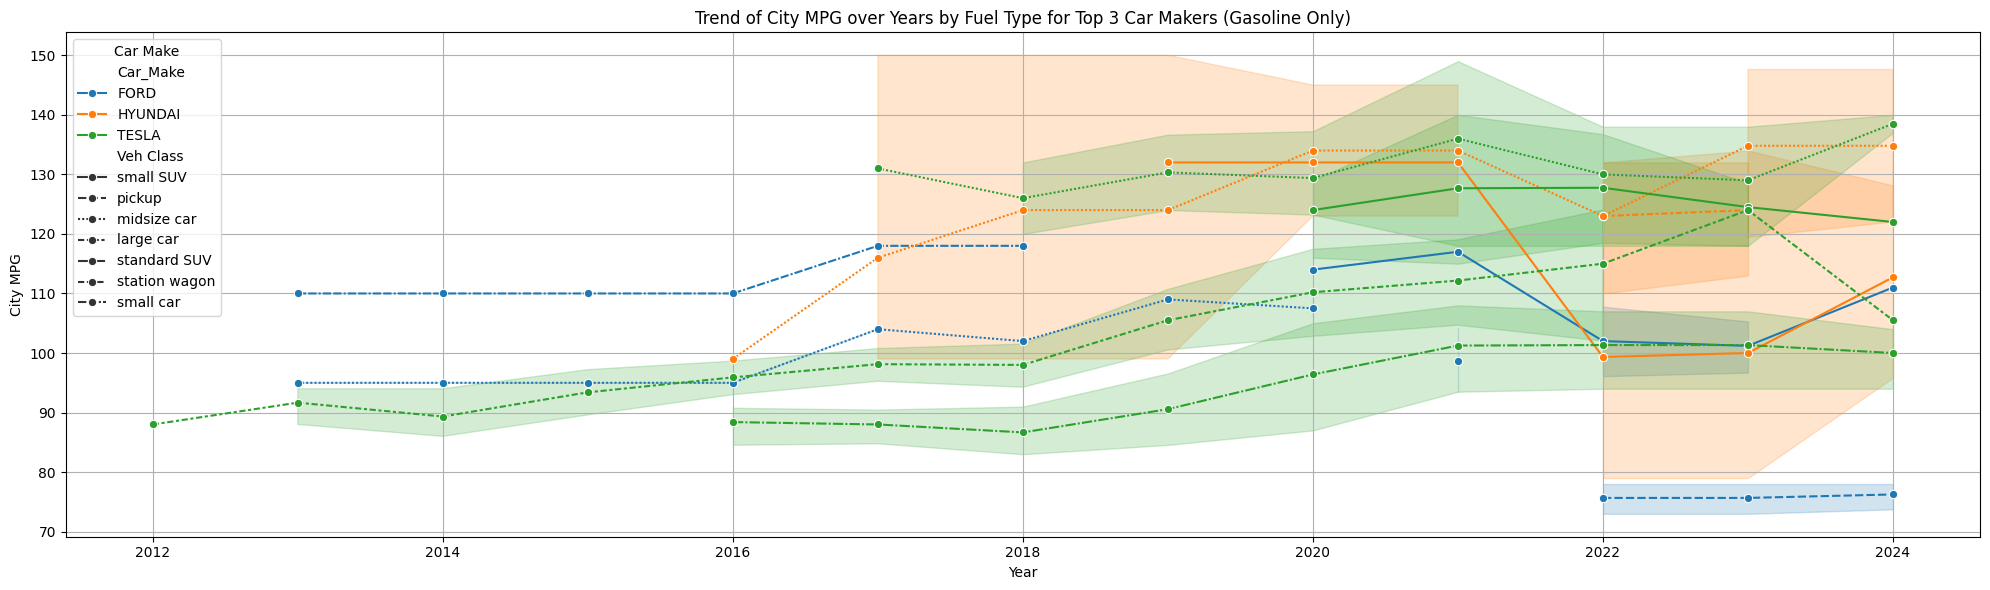

In [45]:
# Filter data for top 3 EV car makers and fuel type electricity
top_3_makers = ['TESLA', 'FORD', 'HYUNDAI']
filtered_data = merged_data[(merged_data['Car_Make'].isin(top_3_makers)) & (merged_data['Fuel'] == 'Electricity')]

# Create the line plot
plt.figure(figsize=(20, 6))
sns.lineplot(data=filtered_data, x='Year', y='City MPG', hue='Car_Make', style = 'Veh Class', marker='o')
plt.title('Trend of City MPG over Years by Fuel Type for Top 3 Car Makers (Gasoline Only)')
plt.xlabel('Year')
plt.ylabel('City MPG')
plt.legend(title='Car Make')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

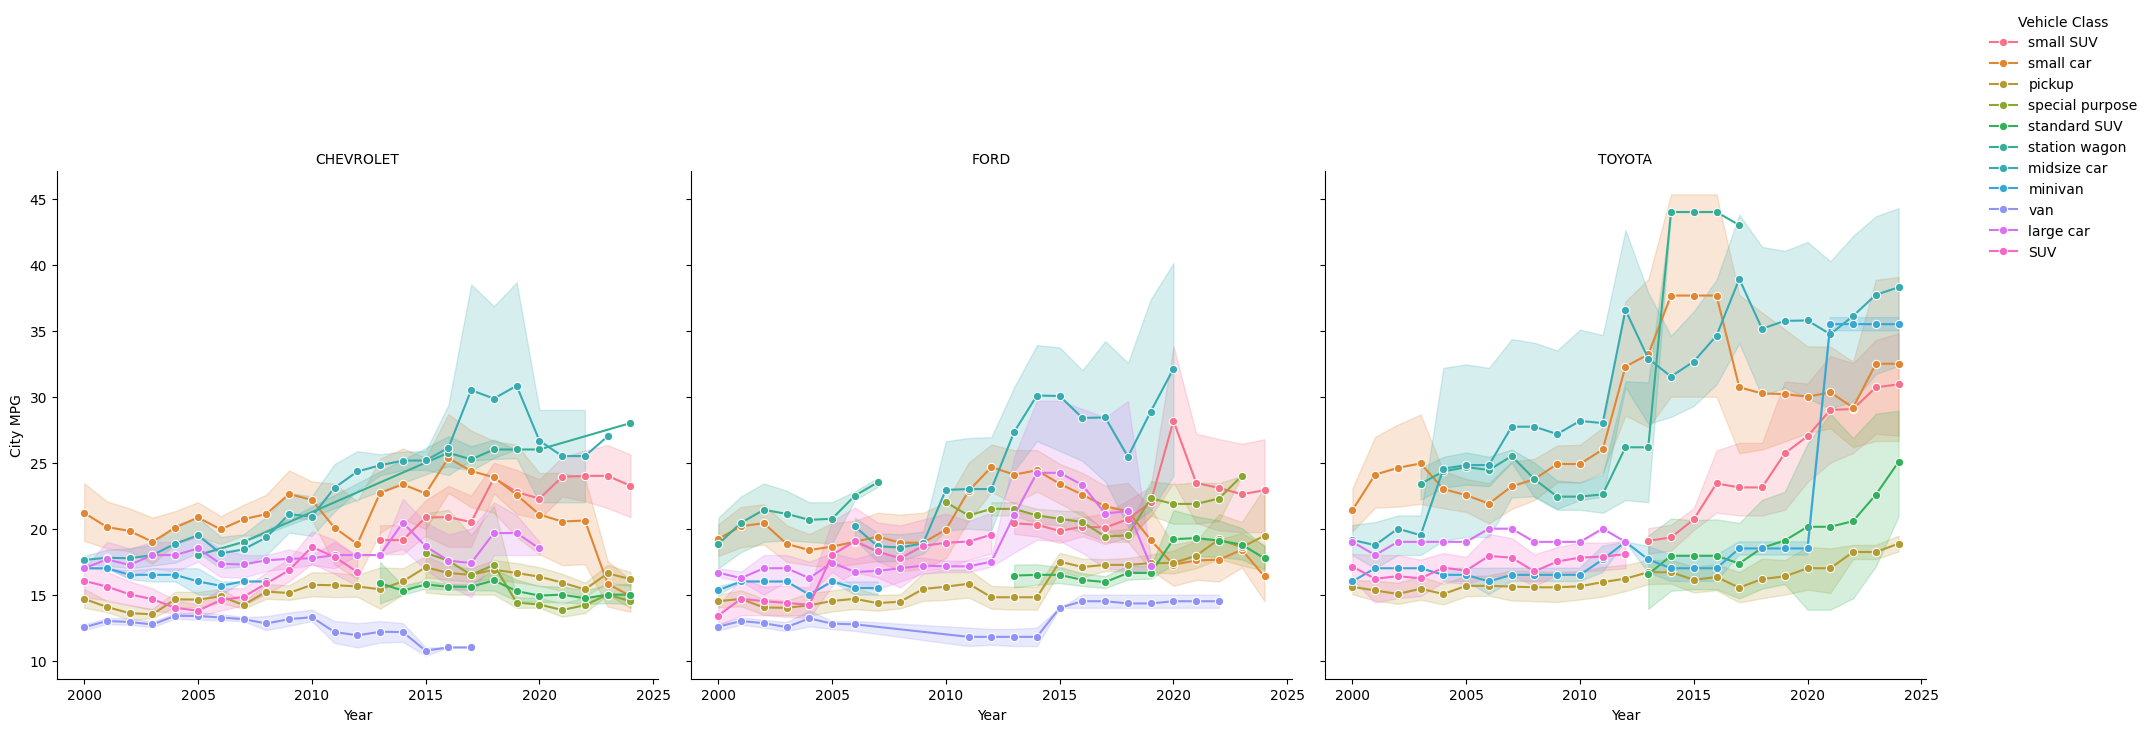

In [46]:
# Filter data for top 3 car makers, fuel type Gasoline, and vehicle class
top_3_makers = ['FORD', 'TOYOTA', 'CHEVROLET']
filtered_data = merged_data[(merged_data['Car_Make'].isin(top_3_makers)) & 
                            (merged_data['Fuel'] == 'Gasoline')]

# Check if there's data for each car make
available_makes = filtered_data['Car_Make'].unique()

# Create a FacetGrid only if there's data for at least one car make
if len(available_makes) > 0:
    # Create a FacetGrid
    g = sns.FacetGrid(filtered_data, col='Car_Make', hue='Veh Class', col_wrap=3, height=6, aspect=1)

    # Map a line plot onto the grid
    g.map(sns.lineplot, 'Year', 'City MPG', marker='o')

    # Set titles, labels, and legend
    g.set_titles('{col_name}')
    g.set_xlabels('Year')
    g.set_ylabels('City MPG')

    # Move legend outside the plot
    g.add_legend(title='Vehicle Class', bbox_to_anchor=(1.1, 1))

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()
else:
    print("No data available for the selected car makes.")

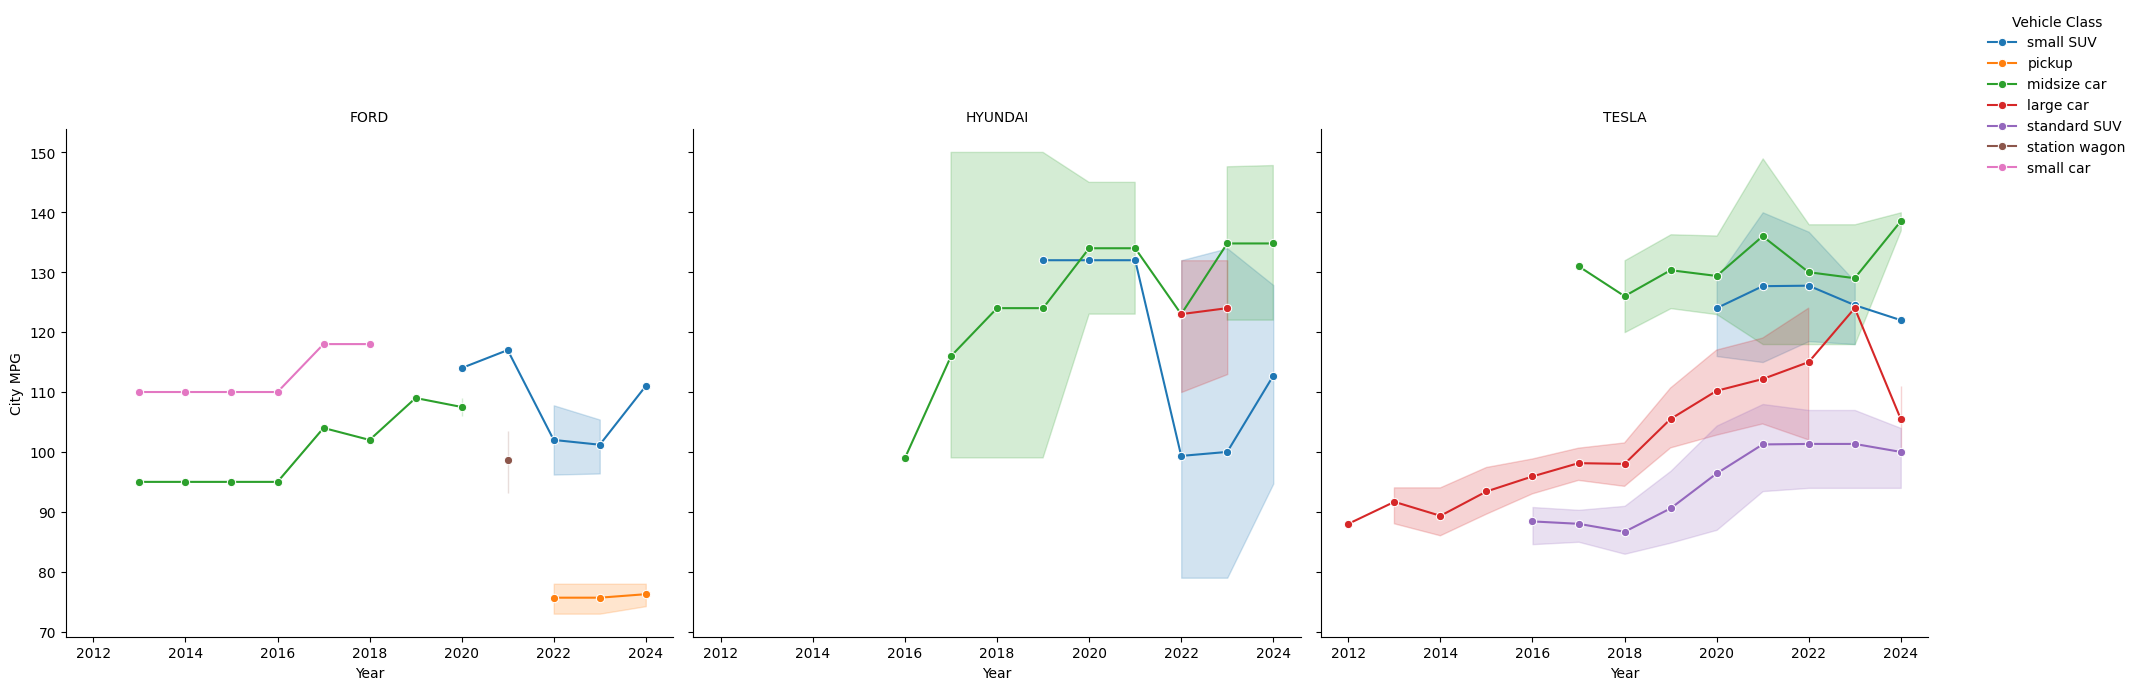

In [47]:
# Filter data for top 3 car makers, fuel type Gasoline, and vehicle class
top_3_makers = ['TESLA', 'FORD', 'HYUNDAI']
filtered_data = merged_data[(merged_data['Car_Make'].isin(top_3_makers)) & 
                            (merged_data['Fuel'] == 'Electricity')]

# Check if there's data for each car make
available_makes = filtered_data['Car_Make'].unique()

# Create a FacetGrid only if there's data for at least one car make
if len(available_makes) > 0:
    # Create a FacetGrid
    g = sns.FacetGrid(filtered_data, col='Car_Make', hue='Veh Class', col_wrap=3, height=6, aspect=1)

    # Map a line plot onto the grid
    g.map(sns.lineplot, 'Year', 'City MPG', marker='o')

    # Set titles, labels, and legend
    g.set_titles('{col_name}')
    g.set_xlabels('Year')
    g.set_ylabels('City MPG')

    # Move legend outside the plot
    g.add_legend(title='Vehicle Class', bbox_to_anchor=(1.1, 1))

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()
else:
    print("No data available for the selected car makes.")

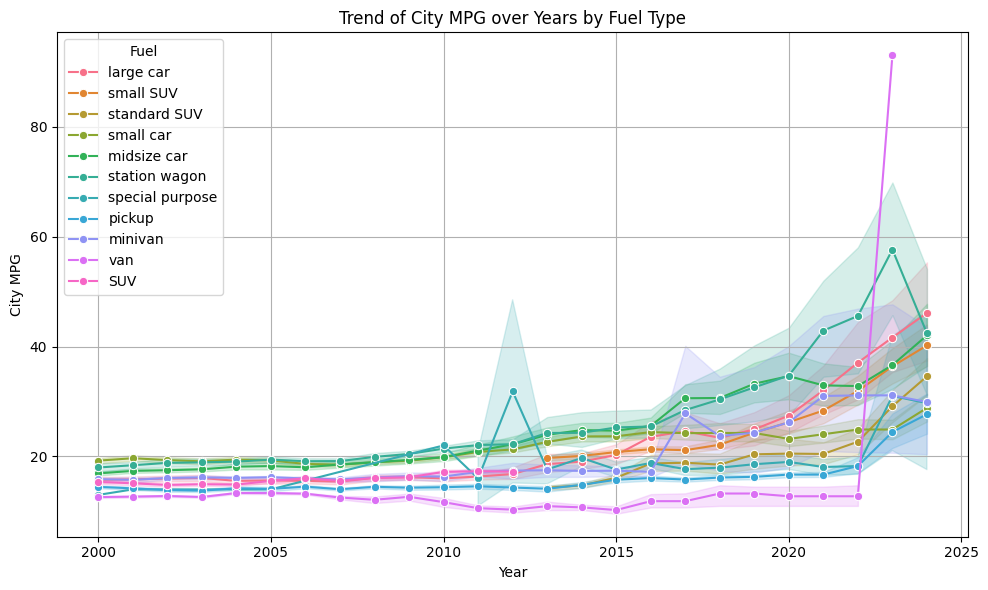

In [48]:
# Create the line plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=merged_data, x='Year', y='City MPG', hue='Veh Class', marker='o')
plt.title('Trend of City MPG over Years by Fuel Type')
plt.xlabel('Year')
plt.ylabel('City MPG')
plt.legend(title='Fuel')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

/tmp/ipykernel_537/2066428578.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=merged_data_no_van, x='Year', y='City MPG', hue='Veh Class', marker='o', ci=None, errorbar=None)


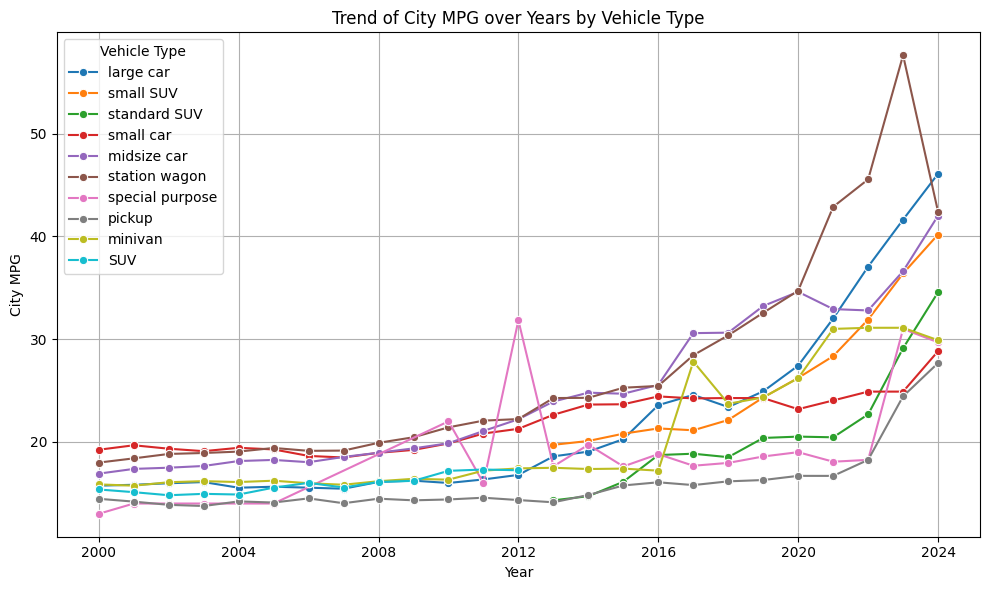

In [103]:
merged_data_no_van = merged_data[merged_data['Veh Class'] != 'van']

# Create the line plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=merged_data_no_van, x='Year', y='City MPG', hue='Veh Class', marker='o', ci=None, errorbar=None)
plt.title('Trend of City MPG over Years by Vehicle Type')
plt.xlabel('Year')
plt.ylabel('City MPG')
plt.legend(title='Vehicle Type')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

/tmp/ipykernel_537/2529320582.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=merged_data_no_van_gasoline, x='Year', y='City MPG', hue='Veh Class', marker='o', ci=None, errorbar=None)


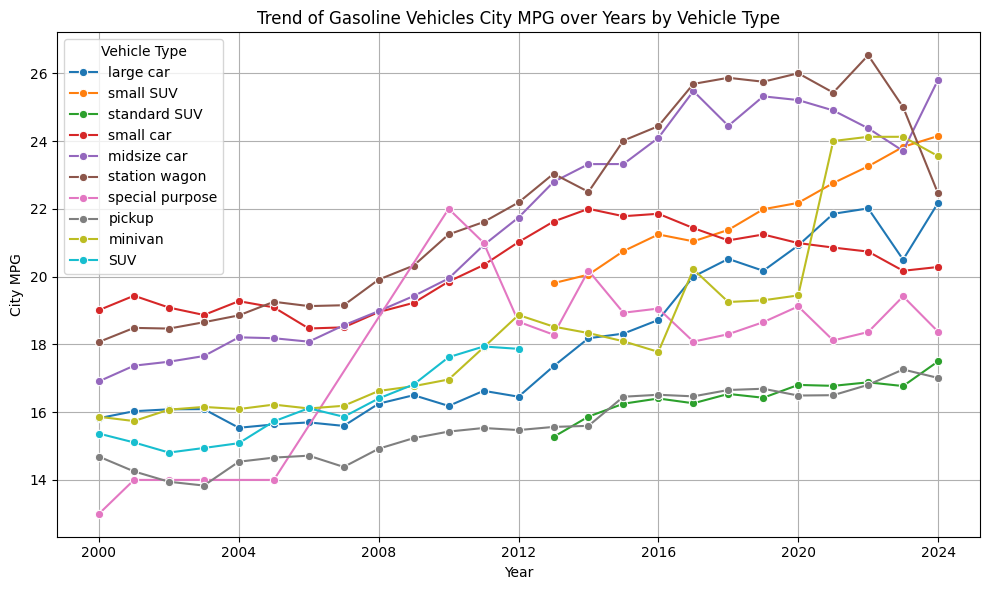

In [104]:
merged_data_no_van = merged_data[merged_data['Veh Class'] != 'van']
merged_data_no_van_gasoline = merged_data_no_van[merged_data_no_van['Fuel'] == 'Gasoline']

# Create the line plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=merged_data_no_van_gasoline, x='Year', y='City MPG', hue='Veh Class', marker='o', ci=None, errorbar=None)
plt.title('Trend of Gasoline Vehicles City MPG over Years by Vehicle Type')
plt.xlabel('Year')
plt.ylabel('City MPG')
plt.legend(title='Vehicle Type')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

/tmp/ipykernel_537/3502617780.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=merged_data_no_van_electricity, x='Year', y='City MPG', hue='Veh Class', marker='o', ci=None, errorbar=None)


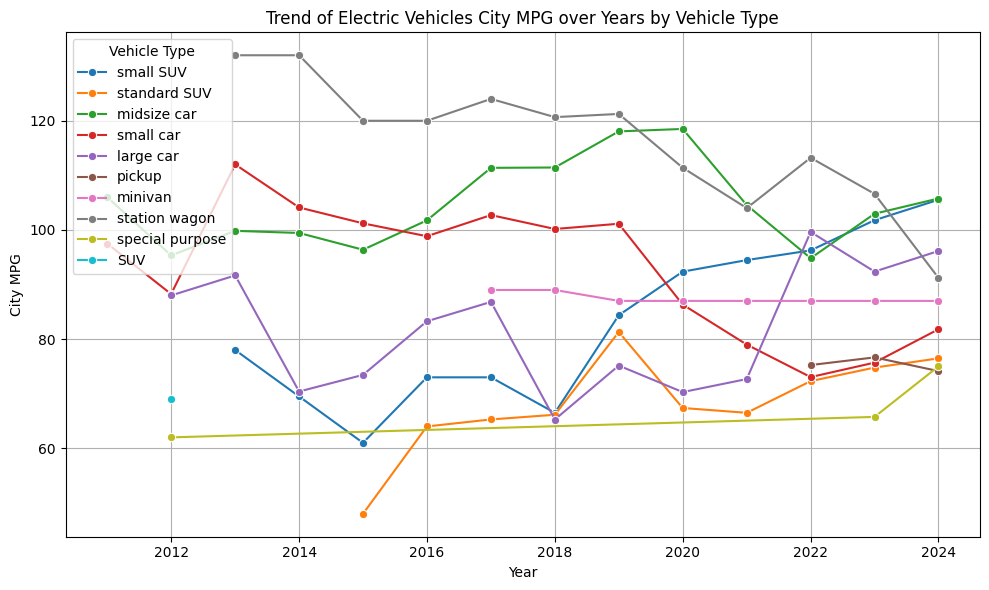

In [105]:
merged_data_no_van = merged_data[merged_data['Veh Class'] != 'van']
merged_data_no_van_electricity = merged_data_no_van[merged_data_no_van['Fuel'] == 'Electricity']

# Create the line plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=merged_data_no_van_electricity, x='Year', y='City MPG', hue='Veh Class', marker='o', ci=None, errorbar=None)
plt.title('Trend of Electric Vehicles City MPG over Years by Vehicle Type')
plt.xlabel('Year')
plt.ylabel('City MPG')
plt.legend(title='Vehicle Type')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

In [50]:
# # Create a Facet Grid plot
# g = sns.FacetGrid(merged_data, col='Veh Class', hue='Fuel', margin_titles=True, height=4, aspect=2)
# g.map(sns.lineplot, 'Year', 'City MPG', marker='o')
# g.set_axis_labels('Year', 'City MPG')
# g.add_legend(title='Fuel Type')
# plt.suptitle('Trend of City MPG over Years by Vehicle Class and Fuel Type', y=1.02)
# plt.tight_layout()
# plt.show()

In [51]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Create a Facet Grid plot
# g = sns.FacetGrid(merged_data, col='Fuel', row='Veh Class', hue='Year', margin_titles=True, height=3, aspect=1.5)
# g.map(sns.scatterplot, 'City MPG', 'Year', alpha=0.5, edgecolor='w')
# g.set_axis_labels('City MPG', 'Year')
# # g.add_legend(title='Year')
# plt.suptitle('City MPG over Years by Fuel Type and Vehicle Class', y=1.02)
# plt.tight_layout()
# plt.show()

In [52]:
merged_data.columns

Index(['Displ', 'Cyl', 'Trans', 'Drive', 'Fuel', 'Veh Class',
       'Air Pollution Score', 'City MPG', 'Hwy MPG', 'Cmb MPG',
       'Greenhouse Gas Score', 'Year', 'Car_Make', 'Car_Model', 'IsHybrid'],
      dtype='object')

In [53]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Create a Facet Grid plot
# g = sns.FacetGrid(merged_data, col='Fuel', row='Veh Class', hue='Year', margin_titles=True, height=3, aspect=1.5)
# g.map(sns.lineplot, 'City MPG', 'Year', alpha=0.5)
# g.set_axis_labels('City MPG', 'Year')
# g.add_legend(title='Year')
# plt.suptitle('City MPG over Years by Fuel Type and Vehicle Class', y=1.02)
# plt.tight_layout()
# plt.show()

In [54]:
merged_data['Year'] = pd.to_datetime(merged_data['Year'], format='%Y')

In [55]:
# List of  ELECTRIC car makes we wish to isolate
car_makes = ['FORD', 'TESLA', 'HYUNDAI']
# Step 1: Filter for specific car makes
filtered_data_electric = merged_data[merged_data['Car_Make'].isin(car_makes)]
# Step 2: Filter to include only rows where 'Fuel' is 'Electricity'
electric_vehicles = filtered_data_electric[filtered_data_electric['Fuel'] == 'Electricity']
# Step 3: Sort the data by 'Year'
sorted_electric_vehicles = electric_vehicles.sort_values(by='Year')
# Display the sorted, filtered rows
sorted_electric_vehicles



Displ  Cyl   Trans Drive         Fuel     Veh Class  \
22271    NaN  NaN  Auto-1   2WD  Electricity     large car   
18995    2.0  4.0     CVT   2WD  Electricity   midsize car   
18997    2.0  4.0     CVT   2WD  Electricity   midsize car   
19094    NaN  NaN  Auto-1   2WD  Electricity     small car   
20232    NaN  NaN  Auto-1   2WD  Electricity     large car   
...      ...  ...     ...   ...          ...           ...   
1137     NaN  NaN  Auto-1   4WD  Electricity  standard SUV   
1138     NaN  NaN  Auto-1   4WD  Electricity  standard SUV   
1139     NaN  NaN  Auto-1   4WD  Electricity     small SUV   
552      NaN  NaN  Auto-1   2WD  Electricity   midsize car   
393      2.5  4.0     CVT   2WD  Electricity     small SUV   

      Air Pollution Score  City MPG Hwy MPG Cmb MPG Greenhouse Gas Score  \
22271                  10      88.0      90      89                   10   
18995                   7      95.0   36/81   38/88                   10   
18997                   9      95.0   36/81   38/88                   10   
19094                  10     110.0      99     105                   10   
20232                  10      94.0      97      95                   10   
...                   ...       ...     ...     ...                  ...   
1137                   10     102.0      92      98                 10.0   
1138                   10      94.0      86      90                 10.0   
1139                   10     122.0     112     117                 10.0   
552                    10     129.0     105     117                 10.0   
393                     8     111.0   37/91  40/101                 10.0   

            Year Car_Make                             Car_Model  \
22271 2012-01-01    TESLA                               Model S   
18995 2013-01-01     FORD                            C-MAX PHEV   
18997 2013-01-01     FORD                            C-MAX PHEV   
19094 2013-01-01     FORD                             Focus BEV   
20232 2013-01-01    TESLA                               Model S   
...          ...      ...                                   ...   
1137  2024-01-01    TESLA            Model X Plaid (20" Wheels)   
1138  2024-01-01    TESLA            Model X Plaid (22" Wheels)   
1139  2024-01-01    TESLA                    Model Y Long Range   
552   2024-01-01  HYUNDAI  Ioniq 6 Long range RWD (20'' Wheels)   
393   2024-01-01     FORD                           Escape PHEV   

              IsHybrid  
22271       Not Hybrid  
18995  Electric Hybrid  
18997  Electric Hybrid  
19094       Not Hybrid  
20232       Not Hybrid  
...                ...  
1137        Not Hybrid  
1138        Not Hybrid  
1139        Not Hybrid  
552         Not Hybrid  
393    Electric Hybrid  

[258 rows x 15 columns]

In [56]:
# Now the gasoline version
# List of car makes we wish to isolate
car_makes = ['FORD', 'CHEVROLET', 'TOYOTA']
# Step 1: Filter for specific car makes
filtered_data_gasoline = merged_data[merged_data['Car_Make'].isin(car_makes)]
# Step 2: Filter to include only rows where 'Fuel' is 'Gasoline'
gasoline_vehicles = filtered_data_gasoline[filtered_data_gasoline['Fuel'] == 'Gasoline']
# Step 3: Sort the data by 'Year'
sorted_gasoline_vehicles = gasoline_vehicles.sort_values(by='Year')
# Display the sorted, filtered rows
sorted_gasoline_vehicles

Displ  Cyl       Trans Drive      Fuel    Veh Class  \
41181    4.7  8.0     Auto-L4   4WD  Gasoline       pickup   
40120    4.8  8.0     Auto-L4   2WD  Gasoline          SUV   
40121    4.8  8.0     Auto-L4   2WD  Gasoline          SUV   
40122    4.8  8.0     Auto-L4   4WD  Gasoline          SUV   
40123    4.8  8.0     Auto-L4   2WD  Gasoline          SUV   
...      ...  ...         ...   ...       ...          ...   
1149     2.5  4.0  SemiAuto-8   2WD  Gasoline  midsize car   
1148     3.5  6.0  SemiAuto-8   2WD  Gasoline  midsize car   
1147     2.5  4.0  SemiAuto-8   4WD  Gasoline  midsize car   
1145     2.5  4.0       SCV-6   2WD  Gasoline  midsize car   
249      2.0  4.0      Auto-9   2WD  Gasoline    small SUV   

      Air Pollution Score  City MPG Hwy MPG Cmb MPG Greenhouse Gas Score  \
41181                   0      13.0      16      14                    2   
40120                   0      13.0      17      14                    2   
40121                   0      13.0      18      15                    3   
40122                   0      13.0      16      14                    2   
40123                   0      13.0      17      14                    2   
...                   ...       ...     ...     ...                  ...   
1149                    7      27.0      38      31                  6.0   
1148                    5      22.0      31      25                  5.0   
1147                    6      25.0      34      29                  6.0   
1145                    7      44.0      47      46                  8.0   
249                     7      22.0      29      25                  5.0   

            Year   Car_Make                Car_Model    IsHybrid  
41181 2000-01-01     TOYOTA                   Tundra  Not Hybrid  
40120 2000-01-01  CHEVROLET               Tahoe 1500  Not Hybrid  
40121 2000-01-01  CHEVROLET               Tahoe 1500  Not Hybrid  
40122 2000-01-01  CHEVROLET               Tahoe 1500  Not Hybrid  
40123 2000-01-01  CHEVROLET               Tahoe 1500  Not Hybrid  
...          ...        ...                      ...         ...  
1149  2024-01-01     TOYOTA            Camry XLE/XSE  Not Hybrid  
1148  2024-01-01     TOYOTA                Camry TRD  Not Hybrid  
1147  2024-01-01     TOYOTA              Camry LE/SE  Not Hybrid  
1145  2024-01-01     TOYOTA  Camry Hybrid SE/XLE/XSE  Not Hybrid  
249   2024-01-01  CHEVROLET                   Blazer  Not Hybrid  

[7583 rows x 15 columns]

In [57]:
#GASOLINE filtered data and average

if all(col in sorted_gasoline_vehicles.columns for col in ['Year', 'City MPG', 'Fuel', 'Car_Make']):
    # Filter the dataset for the years 2000 to 2024
    filtered_data_gasoline = sorted_gasoline_vehicles[(sorted_gasoline_vehicles['Year'] >= '2000-01-01') & (sorted_gasoline_vehicles['Year'] <= '2024-01-01')]
    # Further filter the dataset to include only the specified 'Fuel' types
    fuel_types = ['Gasoline', 'Electricity', 'Gasoline/Electricity']
    filtered_data_gasoline = filtered_data_gasoline[filtered_data_gasoline['Fuel'].isin(fuel_types)]
    # Group by 'Year', 'Fuel', and 'Car_Make', and calculate the average 'City MPG'
    sorted_gasoline_vehicles = filtered_data_gasoline.groupby(['Year', 'Fuel', 'Car_Make'])['City MPG'].mean().reset_index()
    # Rename columns for clarity
    sorted_gasoline_vehicles.columns = ['Year', 'Fuel', 'Car Make', 'Average City MPG']
    pd.set_option('display.max_rows', 1500)
    # Print or inspect the results
    print(sorted_gasoline_vehicles)
else:
    print("The dataset does not contain the necessary 'Year', 'City MPG', 'Fuel', and 'Car_Make' columns.")

         Year      Fuel   Car Make  Average City MPG
0  2000-01-01  Gasoline  CHEVROLET         16.042683
1  2000-01-01  Gasoline       FORD         15.540984
2  2000-01-01  Gasoline     TOYOTA         17.666667
3  2001-01-01  Gasoline  CHEVROLET         15.113636
4  2001-01-01  Gasoline       FORD         15.923810
5  2001-01-01  Gasoline     TOYOTA         18.769231
6  2002-01-01  Gasoline  CHEVROLET         14.877551
7  2002-01-01  Gasoline       FORD         15.848485
8  2002-01-01  Gasoline     TOYOTA         18.724138
9  2003-01-01  Gasoline  CHEVROLET         14.167702
10 2003-01-01  Gasoline       FORD         15.427273
11 2003-01-01  Gasoline     TOYOTA         19.190476
12 2004-01-01  Gasoline  CHEVROLET         15.240741
13 2004-01-01  Gasoline       FORD         16.154762
14 2004-01-01  Gasoline     TOYOTA         19.567010
15 2005-01-01  Gasoline  CHEVROLET         15.481132
16 2005-01-01  Gasoline       FORD         16.880952
17 2005-01-01  Gasoline     TOYOTA         19.

In [58]:
#ELECTRIC filtered data and average

if all(col in sorted_electric_vehicles.columns for col in ['Year', 'City MPG', 'Fuel', 'Car_Make']):
    # Filter the dataset for the years 2000 to 2024
    filtered_data_electric = sorted_electric_vehicles[(sorted_electric_vehicles['Year'] >= '2000-01-01') & (sorted_electric_vehicles['Year'] <= '2024-01-01')]
    # Further filter the dataset to include only the specified 'Fuel' types
    fuel_types = ['Gasoline', 'Electricity', 'Gasoline/Electricity']
    filtered_data_electric = filtered_data_electric[filtered_data_electric['Fuel'].isin(fuel_types)]
    # Group by 'Year', 'Fuel', and 'Car_Make', and calculate the average 'City MPG'
    sorted_electric_vehicles = filtered_data_electric.groupby(['Year', 'Fuel', 'Car_Make'])['City MPG'].mean().reset_index()
    # Rename columns for clarity
    sorted_electric_vehicles.columns = ['Year', 'Fuel', 'Car Make', 'Average City MPG']
    pd.set_option('display.max_rows', 1500)
    # Print or inspect the results
    print(sorted_electric_vehicles)
else:
    print("The dataset does not contain the necessary 'Year', 'City MPG', 'Fuel', and 'Car_Make' columns.")

         Year         Fuel Car Make  Average City MPG
0  2012-01-01  Electricity    TESLA         88.000000
1  2013-01-01  Electricity     FORD         98.000000
2  2013-01-01  Electricity    TESLA         91.666667
3  2014-01-01  Electricity     FORD         98.000000
4  2014-01-01  Electricity    TESLA         89.333333
5  2015-01-01  Electricity     FORD         98.000000
6  2015-01-01  Electricity    TESLA         93.400000
7  2016-01-01  Electricity     FORD         98.000000
8  2016-01-01  Electricity  HYUNDAI         99.000000
9  2016-01-01  Electricity    TESLA         93.562500
10 2017-01-01  Electricity     FORD        106.800000
11 2017-01-01  Electricity  HYUNDAI        116.000000
12 2017-01-01  Electricity    TESLA         96.266667
13 2018-01-01  Electricity     FORD        110.000000
14 2018-01-01  Electricity  HYUNDAI        124.000000
15 2018-01-01  Electricity    TESLA        105.090909
16 2019-01-01  Electricity     FORD        109.000000
17 2019-01-01  Electricity  

In [59]:
sorted_gasoline_vehicles

Year      Fuel   Car Make  Average City MPG
0  2000-01-01  Gasoline  CHEVROLET         16.042683
1  2000-01-01  Gasoline       FORD         15.540984
2  2000-01-01  Gasoline     TOYOTA         17.666667
3  2001-01-01  Gasoline  CHEVROLET         15.113636
4  2001-01-01  Gasoline       FORD         15.923810
5  2001-01-01  Gasoline     TOYOTA         18.769231
6  2002-01-01  Gasoline  CHEVROLET         14.877551
7  2002-01-01  Gasoline       FORD         15.848485
8  2002-01-01  Gasoline     TOYOTA         18.724138
9  2003-01-01  Gasoline  CHEVROLET         14.167702
10 2003-01-01  Gasoline       FORD         15.427273
11 2003-01-01  Gasoline     TOYOTA         19.190476
12 2004-01-01  Gasoline  CHEVROLET         15.240741
13 2004-01-01  Gasoline       FORD         16.154762
14 2004-01-01  Gasoline     TOYOTA         19.567010
15 2005-01-01  Gasoline  CHEVROLET         15.481132
16 2005-01-01  Gasoline       FORD         16.880952
17 2005-01-01  Gasoline     TOYOTA         19.648148
18 2006-01-01  Gasoline  CHEVROLET         15.792793
19 2006-01-01  Gasoline       FORD         17.609756
20 2006-01-01  Gasoline     TOYOTA         19.490000
21 2007-01-01  Gasoline  CHEVROLET         15.218274
22 2007-01-01  Gasoline       FORD         16.952381
23 2007-01-01  Gasoline     TOYOTA         20.010638
24 2008-01-01  Gasoline  CHEVROLET         16.311258
25 2008-01-01  Gasoline       FORD         16.394231
26 2008-01-01  Gasoline     TOYOTA         20.020000
27 2009-01-01  Gasoline  CHEVROLET         17.162651
28 2009-01-01  Gasoline       FORD         17.812500
29 2009-01-01  Gasoline     TOYOTA         20.132743
30 2010-01-01  Gasoline  CHEVROLET         18.961538
31 2010-01-01  Gasoline       FORD         18.941860
32 2010-01-01  Gasoline     TOYOTA         20.366071
33 2011-01-01  Gasoline  CHEVROLET         17.545455
34 2011-01-01  Gasoline       FORD         18.710526
35 2011-01-01  Gasoline     TOYOTA         20.116505
36 2012-01-01  Gasoline  CHEVROLET         17.417476
37 2012-01-01  Gasoline       FORD         19.696429
38 2012-01-01  Gasoline     TOYOTA         23.824176
39 2013-01-01  Gasoline  CHEVROLET         19.527778
40 2013-01-01  Gasoline       FORD         20.322034
41 2013-01-01  Gasoline     TOYOTA         22.318966
42 2014-01-01  Gasoline  CHEVROLET         20.384615
43 2014-01-01  Gasoline       FORD         21.308824
44 2014-01-01  Gasoline     TOYOTA         23.282051
45 2015-01-01  Gasoline  CHEVROLET         20.150442
46 2015-01-01  Gasoline       FORD         21.772059
47 2015-01-01  Gasoline     TOYOTA         23.884615
48 2016-01-01  Gasoline  CHEVROLET         20.636364
49 2016-01-01  Gasoline       FORD         21.012739
50 2016-01-01  Gasoline     TOYOTA         25.404040
51 2017-01-01  Gasoline  CHEVROLET         20.017699
52 2017-01-01  Gasoline       FORD         19.896296
53 2017-01-01  Gasoline     TOYOTA         26.486486
54 2018-01-01  Gasoline  CHEVROLET         21.522727
55 2018-01-01  Gasoline       FORD         19.386139
56 2018-01-01  Gasoline     TOYOTA         25.816667
57 2019-01-01  Gasoline  CHEVROLET         19.800000
58 2019-01-01  Gasoline       FORD         19.532609
59 2019-01-01  Gasoline     TOYOTA         26.419355
60 2020-01-01  Gasoline  CHEVROLET         18.351351
61 2020-01-01  Gasoline       FORD         21.585714
62 2020-01-01  Gasoline     TOYOTA         27.983871
63 2021-01-01  Gasoline  CHEVROLET         17.802326
64 2021-01-01  Gasoline       FORD         19.853933
65 2021-01-01  Gasoline     TOYOTA         28.750000
66 2022-01-01  Gasoline  CHEVROLET         17.402439
67 2022-01-01  Gasoline       FORD         19.920792
68 2022-01-01  Gasoline     TOYOTA         28.140845
69 2023-01-01  Gasoline  CHEVROLET         17.438596
70 2023-01-01  Gasoline       FORD         19.663265
71 2023-01-01  Gasoline     TOYOTA         29.887324
72 2024-01-01  Gasoline  CHEVROLET         16.833333
73 2024-01-01  Gasoline       FORD         19.983051
74 2024-01-01  Gasoline     TOYOTA

In [60]:
#6 filtered data sets

# GASOLINE
#FORD
sorted_gasoline_ford = sorted_gasoline_vehicles[sorted_gasoline_vehicles['Car Make'] == 'FORD']
sorted_gasoline_ford = sorted_gasoline_ford.drop(columns=['Fuel', 'Car Make'])
sorted_gasoline_ford = sorted_gasoline_ford.set_index('Year')
sorted_gasoline_ford = sorted_gasoline_ford['Average City MPG']


#TOYOTA
sorted_gasoline_toyota = sorted_gasoline_vehicles[sorted_gasoline_vehicles['Car Make'] == 'TOYOTA']
sorted_gasoline_toyota = sorted_gasoline_toyota.drop(columns=['Fuel', 'Car Make'])
sorted_gasoline_toyota = sorted_gasoline_toyota.set_index('Year')
sorted_gasoline_toyota = sorted_gasoline_toyota['Average City MPG']

#CHEVROLET
sorted_gasoline_chevrolet = sorted_gasoline_vehicles[sorted_gasoline_vehicles['Car Make'] == 'CHEVROLET']
sorted_gasoline_chevrolet = sorted_gasoline_chevrolet.drop(columns=['Fuel', 'Car Make'])
sorted_gasoline_chevrolet = sorted_gasoline_chevrolet.set_index('Year')
sorted_gasoline_chevrolet = sorted_gasoline_chevrolet['Average City MPG']

#ELECTRIC
#TELSA
sorted_electric_tesla = sorted_electric_vehicles[sorted_electric_vehicles['Car Make'] == 'TESLA']
sorted_electric_tesla = sorted_electric_tesla.drop(columns=['Fuel', 'Car Make'])
sorted_electric_tesla = sorted_electric_tesla.set_index('Year')
sorted_electric_tesla = sorted_electric_tesla['Average City MPG']

#HYUNDAI
sorted_electric_hyundai = sorted_electric_vehicles[sorted_electric_vehicles['Car Make'] == 'HYUNDAI']
sorted_electric_hyundai = sorted_electric_hyundai.drop(columns=['Fuel', 'Car Make'])
sorted_electric_hyundai = sorted_electric_hyundai.set_index('Year')
sorted_electric_hyundai = sorted_electric_hyundai['Average City MPG']

#FORD
sorted_electric_ford = sorted_electric_vehicles[sorted_electric_vehicles['Car Make'] == 'FORD']
sorted_electric_ford = sorted_electric_ford.drop(columns=['Fuel', 'Car Make'])
sorted_electric_ford = sorted_electric_ford.set_index('Year')
sorted_electric_ford = sorted_electric_ford['Average City MPG']

In [61]:
sorted_electric_ford.to_csv('../src/data/sorted_electric_ford.csv', index_label='Date')

sorted_electric_hyundai.to_csv('../src/data/sorted_electric_hyundai.csv', index_label='Date')

sorted_electric_tesla.to_csv('../src/data/sorted_electric_tesla.csv', index_label='Date')

sorted_gasoline_ford.to_csv('../src/data/sorted_gasoline_ford.csv', index_label='Date')

sorted_gasoline_chevrolet.to_csv('../src/data/sorted_gasoline_chevrolet.csv', index_label='Date')

sorted_gasoline_toyota.to_csv('../src/data/sorted_gasoline_toyota.csv', index_label='Date')

In [62]:
sorted_gasoline_ford

Year
2000-01-01    15.540984
2001-01-01    15.923810
2002-01-01    15.848485
2003-01-01    15.427273
2004-01-01    16.154762
2005-01-01    16.880952
2006-01-01    17.609756
2007-01-01    16.952381
2008-01-01    16.394231
2009-01-01    17.812500
2010-01-01    18.941860
2011-01-01    18.710526
2012-01-01    19.696429
2013-01-01    20.322034
2014-01-01    21.308824
2015-01-01    21.772059
2016-01-01    21.012739
2017-01-01    19.896296
2018-01-01    19.386139
2019-01-01    19.532609
2020-01-01    21.585714
2021-01-01    19.853933
2022-01-01    19.920792
2023-01-01    19.663265
2024-01-01    19.983051
Name: Average City MPG, dtype: float64

In [63]:
# Split data into 80/20 train/test 
##################
# ELECTRIC/TESLA #
##################

train_size_tesla = int(len(sorted_electric_tesla) * 0.8)
train_tesla, test_tesla = sorted_electric_tesla[:train_size_tesla], sorted_electric_tesla[train_size_tesla:]

In [64]:
# Check for stationarity
def test_stationarity(timeseries):
    print("Dickey-Fuller test results:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

# Check for stationarity in the train set
test_stationarity(train_tesla)

Dickey-Fuller test results:


Test Statistic                 0.284450
p-value                        0.976620
#Lags Used                     0.000000
Number of Observations Used    9.000000
Critical Value (1%)           -4.473135
Critical Value (5%)           -3.289881
Critical Value (10%)          -2.772382
dtype: float64

In [65]:
# Apply differencing to train
train_diff_tesla = train_tesla.diff().dropna()
train_diff_tesla

Year
2013-01-01    3.666667
2014-01-01   -2.333333
2015-01-01    4.066667
2016-01-01    0.162500
2017-01-01    2.704167
2018-01-01    8.824242
2019-01-01    2.751196
2020-01-01    8.348371
2021-01-01    0.622024
Name: Average City MPG, dtype: float64

In [66]:
# Check for stationarity again
test_stationarity(train_diff_tesla)

Dickey-Fuller test results:


Test Statistic                -3.199995
p-value                        0.019985
#Lags Used                     0.000000
Number of Observations Used    8.000000
Critical Value (1%)           -4.665186
Critical Value (5%)           -3.367187
Critical Value (10%)          -2.802961
dtype: float64

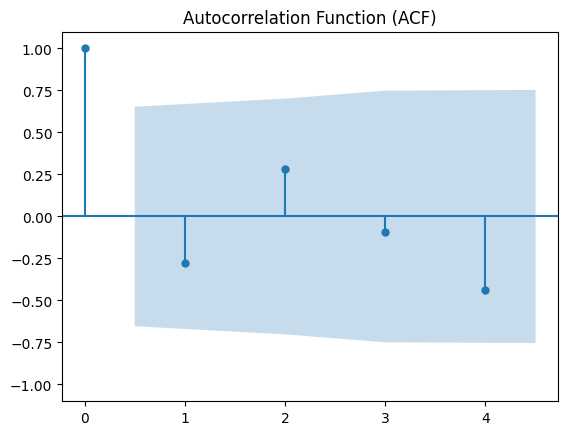

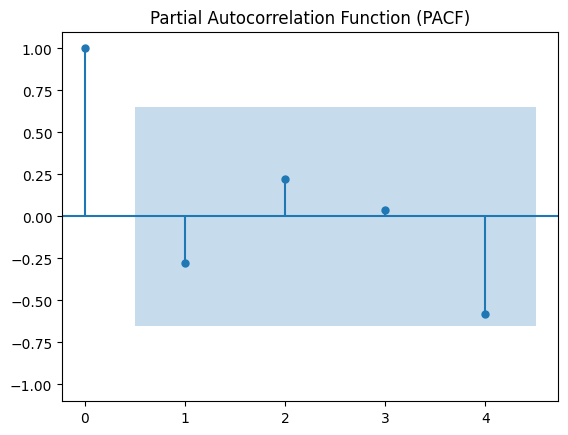

In [67]:
# Plot ACF
fig, ax = plt.subplots()
plot_acf(train_diff_tesla, ax=ax)
ax.set_title('Autocorrelation Function (ACF)')
ax.set_ylim(-1.10, 1.10)  

# Plot PACF
fig, ax = plt.subplots()
plot_pacf(train_diff_tesla, ax=ax)  
ax.set_title('Partial Autocorrelation Function (PACF)')
ax.set_ylim(-1.10, 1.10)  

plt.show()

In [68]:
model_tesla = auto_arima(train_tesla, trace = True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=67.271, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=78.995, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=67.146, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=122.551, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=68.048, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.733 seconds


In [69]:
# Forecast future predictions
forecast_steps_tesla = len(test_tesla)
forecast_tesla, conf_int = model_tesla.predict(n_periods=forecast_steps_tesla, return_conf_int=True)
forecast_tesla

2022-01-01    115.795260
2023-01-01    114.846576
2024-01-01    113.961829
Freq: YS-JAN, dtype: float64

Test RMSE: 3.279


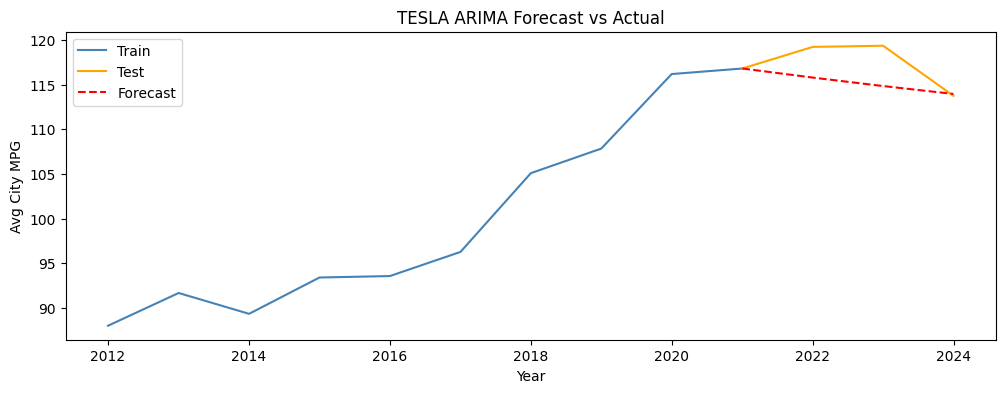

In [70]:
# Calculate RMSE
rmse_tesla = sqrt(mean_squared_error(test_tesla, forecast_tesla))
print('Test RMSE: %.3f' % rmse_tesla)

# Assuming your series is named 'data'
last_element_index_tesla = train_tesla.index[-1]  # Get the index of the last element
last_element_value_tesla = train_tesla.iloc[-1]   # Get the value of the last element

last_element_series_tesla = pd.Series([last_element_value_tesla], index=[last_element_index_tesla])


# Concatenate the two series
forecast_series_tesla = pd.concat([last_element_series_tesla, forecast_tesla])

# Concatenate the two series
test_series_tesla = pd.concat([last_element_series_tesla, test_tesla])

# Plot train, test, and forecasts with confidence intervals
plt.figure(figsize=(12, 4))
plt.plot(train_tesla.index, train_tesla, color='steelblue', label='Train')
plt.plot(test_series_tesla.index, test_series_tesla, color='orange', label='Test')
plt.plot(forecast_series_tesla.index, forecast_series_tesla, color='red', linestyle='--', label='Forecast')

# Plot upper and lower confidence intervals
# plt.fill_between(forecast_tesla.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3, label='Confidence Interval')

plt.title('TESLA ARIMA Forecast vs Actual')
plt.xlabel('Year')
plt.ylabel('Avg City MPG')
plt.legend(loc='upper left')

# Save the plot as an image file
plt.savefig('../src/static/images/electrictesla/arima_forecast_vs_actual.png', dpi=300, bbox_inches='tight')

plt.show()

In [71]:
# Split data into 80/20 train/test 
##################
# ELECTRIC/FORD #
##################

train_size_eford = int(len(sorted_electric_ford) * 0.8)
train_eford, test_eford = sorted_electric_ford[:train_size_eford], sorted_electric_ford[train_size_eford:]

# Check for stationarity in the train set
test_stationarity(train_eford)

Dickey-Fuller test results:


Test Statistic                -1.312657
p-value                        0.623362
#Lags Used                     0.000000
Number of Observations Used    8.000000
Critical Value (1%)           -4.665186
Critical Value (5%)           -3.367187
Critical Value (10%)          -2.802961
dtype: float64

In [72]:
# Apply differencing to train
train_diff_eford = train_eford.diff().dropna()
train_diff_eford

# Check for stationarity again
test_stationarity(train_diff_eford)

Dickey-Fuller test results:


Test Statistic                -1.188194
p-value                        0.678654
#Lags Used                     0.000000
Number of Observations Used    7.000000
Critical Value (1%)           -4.938690
Critical Value (5%)           -3.477583
Critical Value (10%)          -2.843868
dtype: float64

(-1.1, 1.1)

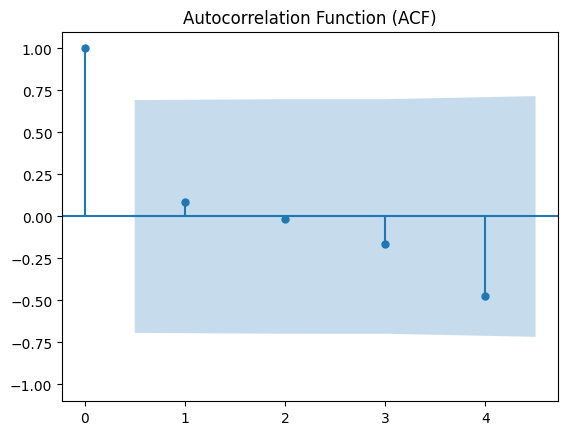

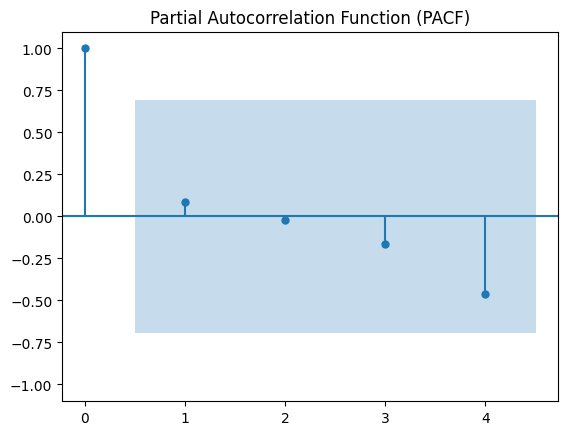

In [73]:
# Plot ACF
fig, ax = plt.subplots()
plot_acf(train_diff_eford, ax=ax)
ax.set_title('Autocorrelation Function (ACF)')
ax.set_ylim(-1.10, 1.10)  

# Plot PACF
fig, ax = plt.subplots()
plot_pacf(train_diff_eford, ax=ax)  
ax.set_title('Partial Autocorrelation Function (PACF)')
ax.set_ylim(-1.10, 1.10)  

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=59.374, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=56.942, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=111.018, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=57.537, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.387 seconds
Test RMSE: 11.991


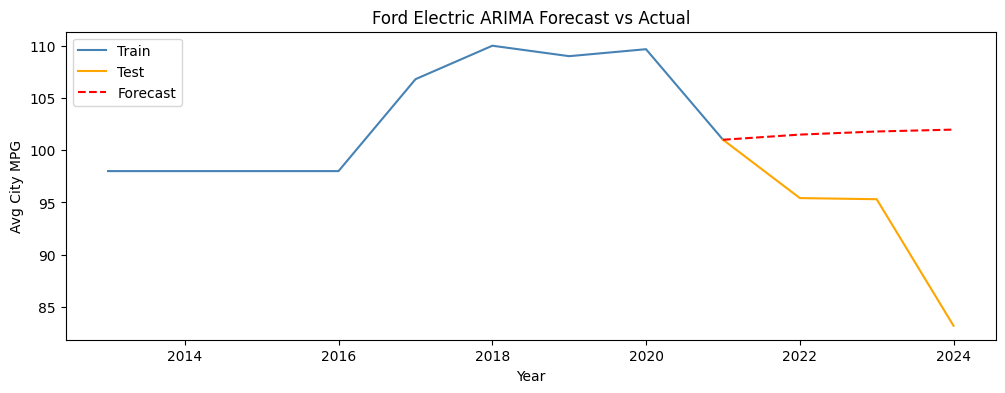

In [74]:
model_eford = auto_arima(train_eford, trace = True)

# Forecast future predictions
forecast_steps_eford = len(test_eford)

forecast_eford, conf_int = model_eford.predict(n_periods=forecast_steps_eford, return_conf_int=True)
forecast_eford

# Calculate RMSE
rmse_eford = sqrt(mean_squared_error(test_eford, forecast_eford))
print('Test RMSE: %.3f' % rmse_eford)

# Assuming your series is named 'data'
last_element_index_eford = train_eford.index[-1]  # Get the index of the last element
last_element_value_eford = train_eford.iloc[-1]   # Get the value of the last element

last_element_series_eford = pd.Series([last_element_value_eford], index=[last_element_index_eford])


# Concatenate the two series
forecast_series_eford = pd.concat([last_element_series_eford, forecast_eford])

# Concatenate the two series
test_series_eford = pd.concat([last_element_series_eford, test_eford])

# Plot train, test, and forecasts with confidence intervals
plt.figure(figsize=(12, 4))
plt.plot(train_eford.index, train_eford, color='steelblue', label='Train')
plt.plot(test_series_eford.index, test_series_eford, color='orange', label='Test')
plt.plot(forecast_series_eford.index, forecast_series_eford, color='red', linestyle='--', label='Forecast')

# Plot upper and lower confidence intervals
# plt.fill_between(forecast_eford.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3, label='Confidence Interval')

plt.title('Ford Electric ARIMA Forecast vs Actual')
plt.xlabel('Year')
plt.ylabel('Avg City MPG')
plt.legend(loc='upper left')

# Save the plot as an image file
plt.savefig('../src/static/images/electricford/arima_forecast_vs_actual.png', dpi=300, bbox_inches='tight')


plt.show()

In [75]:
# Split data into 80/20 train/test 
####################
# ELECTRIC/HYUNDAI #
####################

train_size_ehyundai = int(len(sorted_electric_hyundai) * 0.8)
train_ehyundai, test_ehyundai = sorted_electric_hyundai[:train_size_ehyundai], sorted_electric_hyundai[train_size_ehyundai:]

# Check for stationarity in the train set
test_stationarity(train_ehyundai)

Dickey-Fuller test results:


Test Statistic                -2.469399
p-value                        0.123099
#Lags Used                     0.000000
Number of Observations Used    6.000000
Critical Value (1%)           -5.354256
Critical Value (5%)           -3.646238
Critical Value (10%)          -2.901198
dtype: float64

In [76]:
# Apply differencing to train
train_diff_ehyundai = train_ehyundai.diff().dropna()
train_diff_ehyundai

# Check for stationarity again
test_stationarity(train_diff_ehyundai)

Dickey-Fuller test results:


Test Statistic                 0.094376
p-value                        0.965675
#Lags Used                     0.000000
Number of Observations Used    5.000000
Critical Value (1%)           -6.045114
Critical Value (5%)           -3.929280
Critical Value (10%)          -2.986810
dtype: float64

(-1.1, 1.1)

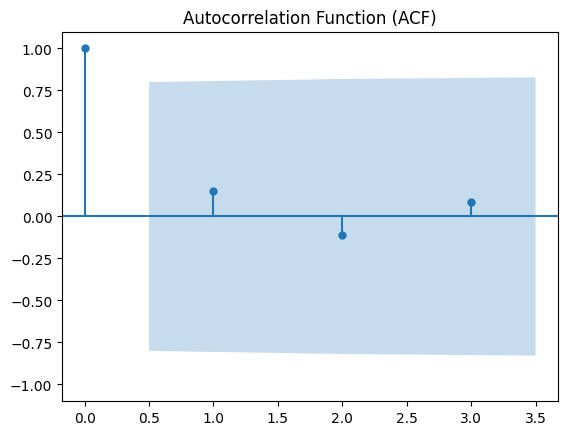

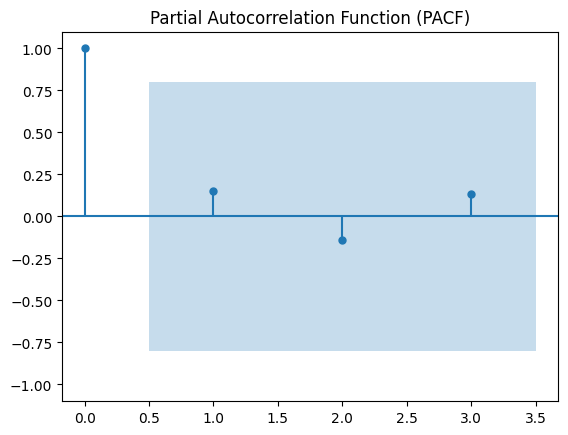

In [77]:
# Plot ACF
fig, ax = plt.subplots()
plot_acf(train_diff_ehyundai, ax=ax)
ax.set_title('Autocorrelation Function (ACF)')
ax.set_ylim(-1.10, 1.10)  

# Plot PACF
fig, ax = plt.subplots()
plot_pacf(train_diff_ehyundai, ax=ax)  
ax.set_title('Partial Autocorrelation Function (PACF)')
ax.set_ylim(-1.10, 1.10)  

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=57.958, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=58.885, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=89.028, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.287 seconds
Test RMSE: 1.511


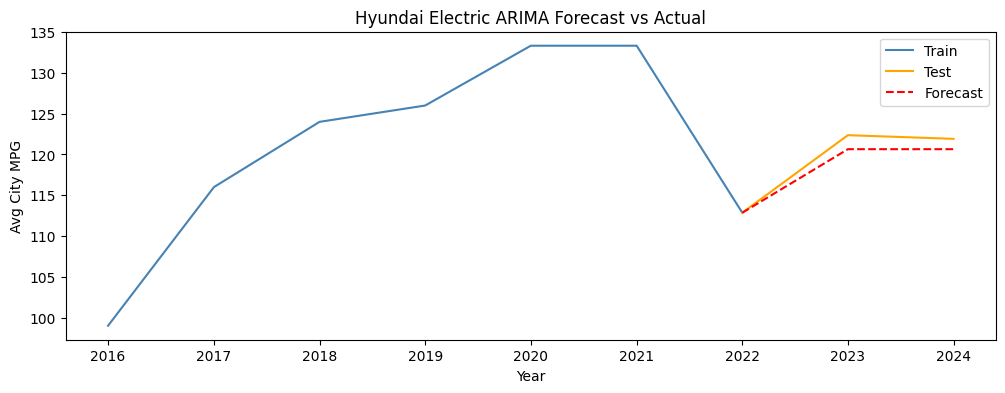

In [78]:
model_ehyundai = auto_arima(train_ehyundai, trace = True)

# Forecast future predictions
forecast_steps_ehyundai = len(test_ehyundai)
forecast_ehyundai, conf_int = model_ehyundai.predict(n_periods=forecast_steps_ehyundai, return_conf_int=True)
forecast_ehyundai

# Calculate RMSE
rmse_ehyundai = sqrt(mean_squared_error(test_ehyundai, forecast_ehyundai))
print('Test RMSE: %.3f' % rmse_ehyundai)

# Assuming your series is named 'data'
last_element_index_ehyundai = train_ehyundai.index[-1]  # Get the index of the last element
last_element_value_ehyundai = train_ehyundai.iloc[-1]   # Get the value of the last element

last_element_series_ehyundai = pd.Series([last_element_value_ehyundai], index=[last_element_index_ehyundai])


# Concatenate the two series
forecast_series_ehyundai = pd.concat([last_element_series_ehyundai, forecast_ehyundai])

# Concatenate the two series
test_series_ehyundai = pd.concat([last_element_series_ehyundai, test_ehyundai])

# Plot train, test, and forecasts with confidence intervals
plt.figure(figsize=(12, 4))
plt.plot(train_ehyundai.index, train_ehyundai, color='steelblue', label='Train')
plt.plot(test_series_ehyundai.index, test_series_ehyundai, color='orange', label='Test')
plt.plot(forecast_series_ehyundai.index, forecast_series_ehyundai, color='red', linestyle='--', label='Forecast')

# Plot upper and lower confidence intervals
# plt.fill_between(forecast_ehyundai.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3, label='Confidence Interval')

plt.title('Hyundai Electric ARIMA Forecast vs Actual')
plt.xlabel('Year')
plt.ylabel('Avg City MPG')
plt.legend()

# Save the plot as an image file
plt.savefig('../src/static/images/electrichyundai/arima_forecast_vs_actual.png', dpi=300, bbox_inches='tight')


plt.show()

In [79]:
# Split data into 80/20 train/test 
####################
# Gasoline/FORD #
####################

train_size_gford = int(len(sorted_gasoline_ford) * 0.8)
train_gford, test_gford = sorted_gasoline_ford[:train_size_gford], sorted_gasoline_ford[train_size_gford:]

# Check for stationarity in the train set
test_stationarity(train_gford)

Dickey-Fuller test results:


Test Statistic                  0.017748
p-value                         0.959975
#Lags Used                      8.000000
Number of Observations Used    11.000000
Critical Value (1%)            -4.223238
Critical Value (5%)            -3.189369
Critical Value (10%)           -2.729839
dtype: float64

In [80]:
# Apply differencing to train
train_diff_gford = train_gford.diff().dropna()
train_diff_gford

# Check for stationarity again
test_stationarity(train_diff_gford)

Dickey-Fuller test results:


Test Statistic                 -3.427063
p-value                         0.010070
#Lags Used                      7.000000
Number of Observations Used    11.000000
Critical Value (1%)            -4.223238
Critical Value (5%)            -3.189369
Critical Value (10%)           -2.729839
dtype: float64

(-1.1, 1.1)

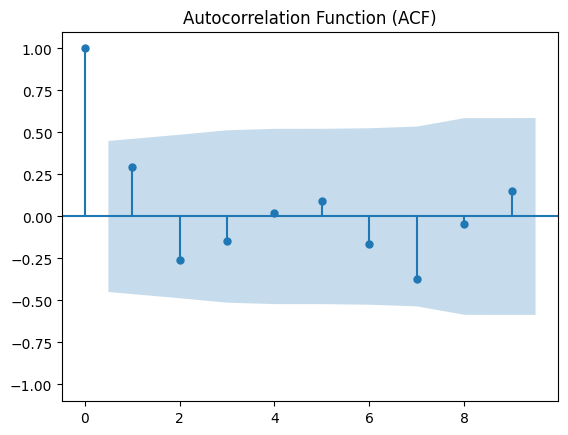

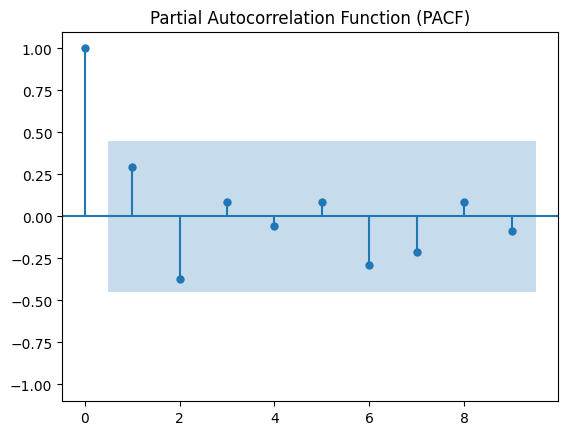

In [81]:
# Plot ACF
fig, ax = plt.subplots()
plot_acf(train_diff_gford, ax=ax)
ax.set_title('Autocorrelation Function (ACF)')
ax.set_ylim(-1.10, 1.10)  

# Plot PACF
fig, ax = plt.subplots()
plot_pacf(train_diff_gford, ax=ax)  
ax.set_title('Partial Autocorrelation Function (PACF)')
ax.set_ylim(-1.10, 1.10)  

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=45.378, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=45.757, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=43.790, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=44.935, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=45.523, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=45.303, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=42.671, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=44.532, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=44.479, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=44.654, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=46.436, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.540 seconds
Test RMSE: 0.893


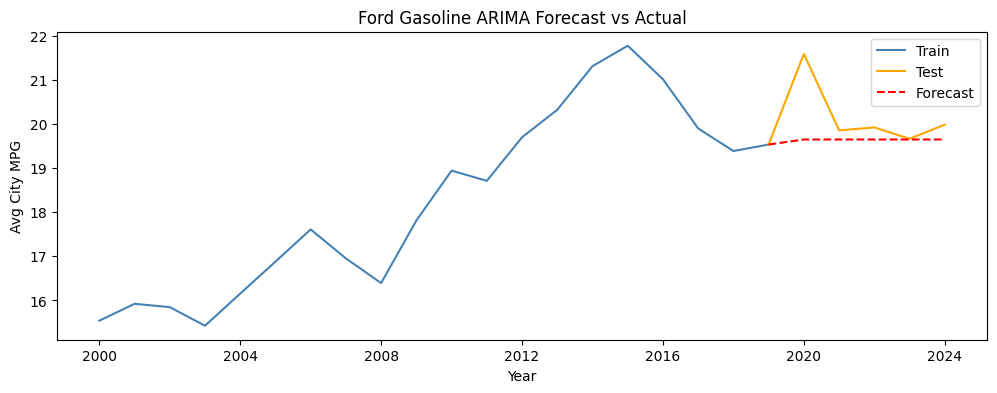

In [82]:
model_gford = auto_arima(train_gford, trace = True)

# Forecast future predictions
forecast_steps_gford = len(test_gford)
forecast_gford, conf_int = model_gford.predict(n_periods=forecast_steps_gford, return_conf_int=True)
forecast_gford

# Calculate RMSE
rmse_gford = sqrt(mean_squared_error(test_gford, forecast_gford))
print('Test RMSE: %.3f' % rmse_gford)

# Assuming your series is named 'data'
last_element_index_gford = train_gford.index[-1]  # Get the index of the last element
last_element_value_gford = train_gford.iloc[-1]   # Get the value of the last element

last_element_series_gford = pd.Series([last_element_value_gford], index=[last_element_index_gford])


# Concatenate the two series
forecast_series_gford = pd.concat([last_element_series_gford, forecast_gford])

# Concatenate the two series
test_series_gford = pd.concat([last_element_series_gford, test_gford])

# Plot train, test, and forecasts with confidence intervals
plt.figure(figsize=(12, 4))
plt.plot(train_gford.index, train_gford, color='steelblue', label='Train')
plt.plot(test_series_gford.index, test_series_gford, color='orange', label='Test')
plt.plot(forecast_series_gford.index, forecast_series_gford, color='red', linestyle='--', label='Forecast')

# Plot upper and lower confidence intervals
# plt.fill_between(forecast_gford.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3, label='Confidence Interval')

plt.title('Ford Gasoline ARIMA Forecast vs Actual')
plt.xlabel('Year')
plt.ylabel('Avg City MPG')
plt.legend()

# Save the plot as an image file
plt.savefig('../src/static/images/gasolineford/arima_forecast_vs_actual.png', dpi=300, bbox_inches='tight')


plt.show()

In [83]:
# Split data into 80/20 train/test 
####################
# Gasoline/CHEVROLET #
####################

train_size_gchev = int(len(sorted_gasoline_chevrolet) * 0.8)
train_gchev, test_gchev = sorted_gasoline_chevrolet[:train_size_gchev], sorted_gasoline_chevrolet[train_size_gchev:]

# Check for stationarity in the train set
test_stationarity(train_gchev)

Dickey-Fuller test results:


Test Statistic                 -2.280279
p-value                         0.178407
#Lags Used                      8.000000
Number of Observations Used    11.000000
Critical Value (1%)            -4.223238
Critical Value (5%)            -3.189369
Critical Value (10%)           -2.729839
dtype: float64

In [84]:
# Apply differencing to train
train_diff_gchev = train_gchev.diff().dropna()
train_diff_gchev

# Check for stationarity again
test_stationarity(train_diff_gchev)

Dickey-Fuller test results:


Test Statistic                 -4.242412
p-value                         0.000558
#Lags Used                      2.000000
Number of Observations Used    16.000000
Critical Value (1%)            -3.924019
Critical Value (5%)            -3.068498
Critical Value (10%)           -2.673893
dtype: float64

(-1.1, 1.1)

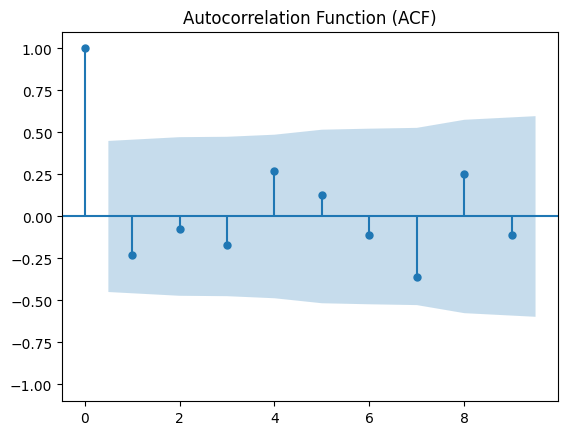

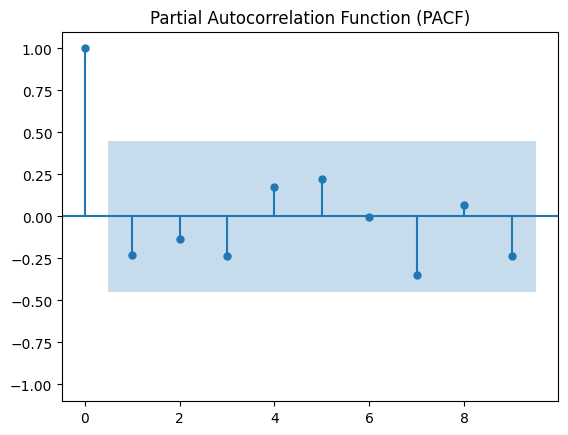

In [85]:
# Plot ACF
fig, ax = plt.subplots()
plot_acf(train_diff_gchev, ax=ax)
ax.set_title('Autocorrelation Function (ACF)')
ax.set_ylim(-1.10, 1.10)  

# Plot PACF
fig, ax = plt.subplots()
plot_pacf(train_diff_gchev, ax=ax)  
ax.set_title('Partial Autocorrelation Function (PACF)')
ax.set_ylim(-1.10, 1.10)  

In [88]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARMA

num_samples_gchev = 10

train_len = int(0.8* num_samples_gchev)


ar_model = AutoReg(train_gchev, lags=1).fit()

print(ar_model.summary())
pred = ar_model.predict(start=train_len, end=num_samples_gchev, dynamic=False)



                            AutoReg Model Results                             
Dep. Variable:       Average City MPG   No. Observations:                   20
Model:                     AutoReg(1)   Log Likelihood                 -27.344
Method:               Conditional MLE   S.D. of innovations              1.020
Date:                Fri, 24 May 2024   AIC                             60.688
Time:                        23:40:49   BIC                             63.521
Sample:                    01-01-2001   HQIC                            61.167
                         - 01-01-2019                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.7736      1.809      0.980      0.327      -1.772       5.319
Average City MPG.L1     0.9097      0.103      8.850      0.000       0.708       1.111
                

/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


In [ ]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
sns.lineplot(x=sample.timestamp[train_len:num_samples], y=sample.t[train_len:num_samples], marker='o', label='test', color='grey')
sns.lineplot(x=sample.timestamp[:train_len], y=train, marker='o', label='train')
sns.lineplot(x=sample.timestamp[train_len:num_samples], y=pred, marker='o', label='pred')
ax.set_xlim([sample.timestamp.iloc[0], sample.timestamp.iloc[-1]])
ax.set_title('Sample Time Series')
plt.tight_layout()
plt.show()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=59.444, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=60.164, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=59.309, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=58.118, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.281 seconds
Test RMSE: 2.290


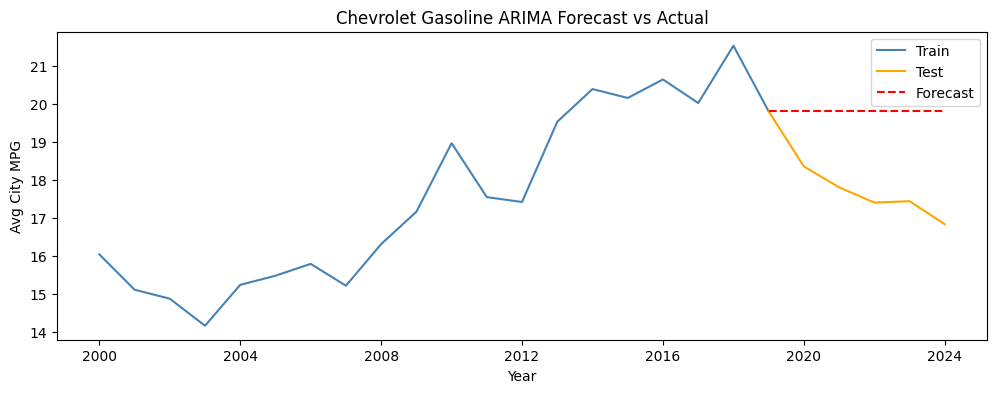

In [106]:
model_gchev = auto_arima(train_gchev, trace = True)

# Forecast future predictions
forecast_steps_gchev = len(test_gchev)
forecast_gchev, conf_int = model_gchev.predict(n_periods=forecast_steps_gchev, return_conf_int=True)
forecast_gchev

# Calculate RMSE
rmse_gchev = sqrt(mean_squared_error(test_gchev, forecast_gchev))
print('Test RMSE: %.3f' % rmse_gchev)

# Assuming your series is named 'data'
last_element_index_gchev = train_gchev.index[-1]  # Get the index of the last element
last_element_value_gchev = train_gchev.iloc[-1]   # Get the value of the last element

last_element_series_gchev = pd.Series([last_element_value_gchev], index=[last_element_index_gchev])


# Concatenate the two series
forecast_series_gchev = pd.concat([last_element_series_gchev, forecast_gchev])

# Concatenate the two series
test_series_gchev = pd.concat([last_element_series_gchev, test_gchev])

# Plot train, test, and forecasts with confidence intervals
plt.figure(figsize=(12, 4))
plt.plot(train_gchev.index, train_gchev, color='steelblue', label='Train')
plt.plot(test_series_gchev.index, test_series_gchev, color='orange', label='Test')
plt.plot(forecast_series_gchev.index, forecast_series_gchev, color='red', linestyle='--', label='Forecast')

# Plot upper and lower confidence intervals
# plt.fill_between(forecast_gchev.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3, label='Confidence Interval')

plt.title('Chevrolet Gasoline ARIMA Forecast vs Actual')
plt.xlabel('Year')
plt.ylabel('Avg City MPG')
plt.legend()

# Save the plot as an image file
plt.savefig('../src/static/images/gasolinechevrolet/arima_forecast_vs_actual.png', dpi=300, bbox_inches='tight')

plt.show()

In [109]:
##################################testing arima model parameters


model_gchev = best_model

# Forecast future predictions
forecast_steps_gchev = len(test_gchev)
forecast_gchev, conf_int = model_gchev.predict(n_periods=forecast_steps_gchev, return_conf_int=True)
forecast_gchev

# Calculate RMSE
rmse_gchev = sqrt(mean_squared_error(test_gchev, forecast_gchev))
print('Test RMSE: %.3f' % rmse_gchev)

# Assuming your series is named 'data'
last_element_index_gchev = train_gchev.index[-1]  # Get the index of the last element
last_element_value_gchev = train_gchev.iloc[-1]   # Get the value of the last element

last_element_series_gchev = pd.Series([last_element_value_gchev], index=[last_element_index_gchev])


# Concatenate the two series
forecast_series_gchev = pd.concat([last_element_series_gchev, forecast_gchev])

# Concatenate the two series
test_series_gchev = pd.concat([last_element_series_gchev, test_gchev])

# Plot train, test, and forecasts with confidence intervals
plt.figure(figsize=(12, 4))
plt.plot(train_gchev.index, train_gchev, color='steelblue', label='Train')
plt.plot(test_series_gchev.index, test_series_gchev, color='orange', label='Test')
plt.plot(forecast_series_gchev.index, forecast_series_gchev, color='red', linestyle='--', label='Forecast')

# Plot upper and lower confidence intervals
# plt.fill_between(forecast_gchev.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3, label='Confidence Interval')

plt.title('Chevrolet Gasoline ARIMA Forecast vs Actual')
plt.xlabel('Year')
plt.ylabel('Avg City MPG')
plt.legend()

# Save the plot as an image file
plt.savefig('../src/static/images/gasolinechevrolet/arima_forecast_vs_actual.png', dpi=300, bbox_inches='tight')

plt.show()

ValueError: too many values to unpack (expected 2)

In [108]:
###################testing arima best model parameters

import itertools

# Define the range for each parameter
p = range(0, 6)
d = range(0, 3)
q = range(0, 6)

# Create a list of all possible combinations of p, d, q
pdq_combinations = list(itertools.product(p, d, q))

# Initialize variables to store the best model and its AIC
best_aic = np.inf
best_pdq = None
best_model = None

# Loop through each combination and fit the model
for pdq in pdq_combinations:
    try:
        model_gchev = ARIMA(test_gchev, order=pdq)
        model_fit = model_gchev.fit()
        aic = model_fit.aic
        # If the current model has a lower AIC than the best one so far, update best model
        if aic < best_aic:
            best_aic = aic
            best_pdq = pdq
            best_model = model_fit
    except Exception as e:
        continue

print(f'Best ARIMA{best_pdq} model - AIC: {best_aic}')

# Print summary of the best model
print(best_model.summary())

/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provi

/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/vscode/.local/lib/python3.10/site-packages/st

Best ARIMA(2, 2, 0) model - AIC: 2.079352968174372
                               SARIMAX Results                                
Dep. Variable:       Average City MPG   No. Observations:                    5
Model:                 ARIMA(2, 2, 0)   Log Likelihood                   1.960
Date:                Sat, 25 May 2024   AIC                              2.079
Time:                        00:17:10   BIC                             -0.625
Sample:                    01-01-2020   HQIC                            -3.356
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1283      2.053     -0.550      0.583      -5.152       2.895
ar.L2         -0.9984      0.006   -178.460      0.000      -1.009      -0.987
s

/home/vscode/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/mlemodel.py:3158: UserWarning: Early subset of data for variable 0 has too few non-missing observations to calculate test statistic.
  test_statistic, p_value = breakvar_heteroskedasticity_test(
/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/mlemodel.py:3158: UserWarning: Later subset of data for variable 0 has too few non-missing observations to calculate test statistic.
  test_statistic, p_value = breakvar_heteroskedasticity_test(


In [ ]:
# Split data into 80/20 train/test 
####################
# Gasoline/TOYOTA #
####################

train_size_gtoy = int(len(sorted_gasoline_toyota) * 0.8)
train_gtoy, test_gtoy = sorted_gasoline_toyota[:train_size_gtoy], sorted_gasoline_toyota[train_size_gtoy:]

# Check for stationarity in the train set
test_stationarity(train_gtoy)

Dickey-Fuller test results:


Test Statistic                  1.129981
p-value                         0.995465
#Lags Used                      7.000000
Number of Observations Used    12.000000
Critical Value (1%)            -4.137829
Critical Value (5%)            -3.154972
Critical Value (10%)           -2.714477
dtype: float64

In [ ]:
# Apply differencing to train
train_diff_gtoy = train_gtoy.diff().dropna()
train_diff_gtoy

# Check for stationarity again
test_stationarity(train_diff_gtoy)

Dickey-Fuller test results:


Test Statistic                -6.847087e+00
p-value                        1.731733e-09
#Lags Used                     0.000000e+00
Number of Observations Used    1.800000e+01
Critical Value (1%)           -3.859073e+00
Critical Value (5%)           -3.042046e+00
Critical Value (10%)          -2.660906e+00
dtype: float64

(-1.1, 1.1)

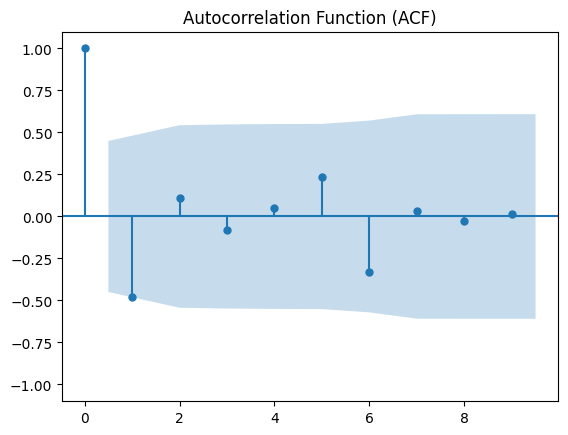

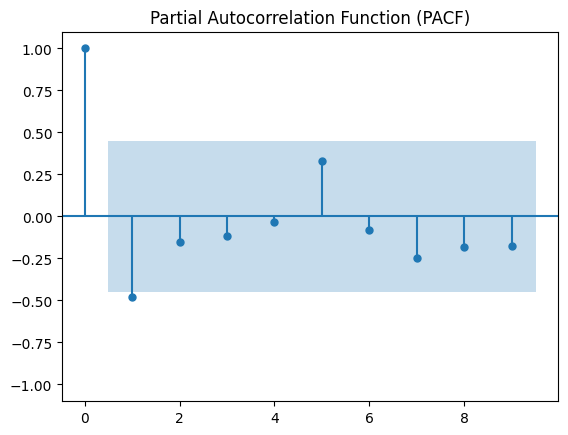

In [ ]:
# Plot ACF
fig, ax = plt.subplots()
plot_acf(train_diff_gtoy, ax=ax)
ax.set_title('Autocorrelation Function (ACF)')
ax.set_ylim(-1.10, 1.10)  

# Plot PACF
fig, ax = plt.subplots()
plot_pacf(train_diff_gtoy, ax=ax)  
ax.set_title('Partial Autocorrelation Function (PACF)')
ax.set_ylim(-1.10, 1.10)  

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=58.484, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=55.637, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=55.425, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=60.043, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=57.129, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=57.063, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=57.721, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=61.231, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 1.050 seconds
Test RMSE: 1.113


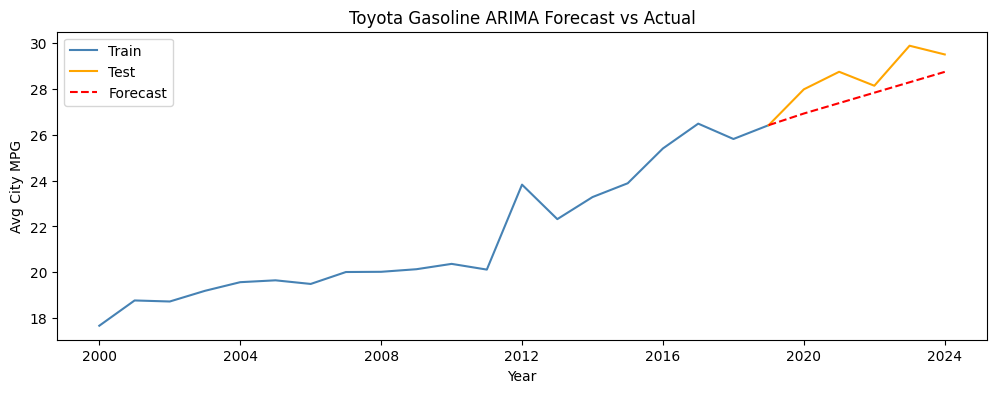

In [ ]:
model_gtoy = auto_arima(train_gtoy, trace = True)

# Forecast future predictions
forecast_steps_gtoy = len(test_gtoy)
forecast_gtoy, conf_int = model_gtoy.predict(n_periods=forecast_steps_gtoy, return_conf_int=True)
forecast_gtoy

# Calculate RMSE
rmse_gtoy = sqrt(mean_squared_error(test_gtoy, forecast_gtoy))
print('Test RMSE: %.3f' % rmse_gtoy)

# Assuming your series is named 'data'
last_element_index_gtoy = train_gtoy.index[-1]  # Get the index of the last element
last_element_value_gtoy = train_gtoy.iloc[-1]   # Get the value of the last element

# Create a Series with the last element and its index
last_element_series_gtoy = pd.Series([last_element_value_gtoy], index=[last_element_index_gtoy])


# Concatenate the two series
forecast_series_gtoy = pd.concat([last_element_series_gtoy, forecast_gtoy])

# Concatenate the two series
test_series_gtoy = pd.concat([last_element_series_gtoy, test_gtoy])

# Plot train, test, and forecasts with confidence intervals
plt.figure(figsize=(12, 4))
plt.plot(train_gtoy.index, train_gtoy, color='steelblue', label='Train')
plt.plot(test_series_gtoy.index, test_series_gtoy, color='orange', label='Test')
plt.plot(forecast_series_gtoy.index, forecast_series_gtoy, color='red', linestyle='--', label='Forecast')

# Plot upper and lower confidence intervals
# plt.fill_between(forecast_gtoy.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3, label='Confidence Interval')

plt.title('Toyota Gasoline ARIMA Forecast vs Actual')
plt.xlabel('Year')
plt.ylabel('Avg City MPG')
plt.legend()

# Save the plot as an image file
plt.savefig('../src/static/images/gasolinetoyota/arima_forecast_vs_actual.png', dpi=300, bbox_inches='tight')

plt.show() 

In [ ]:
#save our models, there too skinny

#tesla
with open('../models/tesla_model.sav', 'wb') as file:
    pickle.dump(model_tesla, file)

#ford_electric
with open('../models/eford_model.sav', 'wb') as file:
    pickle.dump(model_eford, file)

#hyundai electric
with open('../models/ehyundai_model.sav', 'wb') as file:
    pickle.dump(model_ehyundai, file)

#ford
with open('../models/gford_model.sav', 'wb') as file:
    pickle.dump(model_gford, file)

#chevrolet
with open('../models/gchev_model.sav', 'wb') as file:
    pickle.dump(model_gchev, file)

#toyota
with open('../models/gtoy_model.sav', 'wb') as file:
    pickle.dump(model_gtoy, file)

In [ ]:
# Now, retrain the model on the entire dataset
model_tesla.fit(sorted_electric_tesla)



ARIMA(order=(1, 0, 0), scoring_args={}, suppress_warnings=True)

In [ ]:
model_eford.fit(sorted_electric_ford)


ARIMA(order=(1, 0, 0), scoring_args={}, suppress_warnings=True)

In [ ]:
model_ehyundai.fit(sorted_electric_hyundai)


ARIMA(order=(0, 0, 0), scoring_args={}, suppress_warnings=True)

In [ ]:
model_gford.fit(sorted_gasoline_ford)


ARIMA(order=(0, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
model_gchev.fit(sorted_gasoline_chevrolet)


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
model_gtoy.fit(sorted_gasoline_toyota)

ARIMA(order=(0, 1, 1), scoring_args={}, suppress_warnings=True)

In [ ]:
#Electric TESLA
for n in range(1, 31):
    forecast, conf_int = model_tesla.predict(n_periods=n, return_conf_int=True)
    #print(f"forecast: {forecast}")
   
    last_element_index = sorted_electric_tesla.index[-1]  # Get the index of the last ts element
   # print(f"last element index: {last_element_index}")
    
    last_element_value = sorted_electric_tesla.iloc[-1]   # Get the value of the last ts element
   # print(f"last element value: {last_element_value}")
    
    # Create a Series with the last element and its index
    last_element_series = pd.Series(last_element_value, index=[last_element_index])
   # print(f"last element series: {last_element_series}")


    # Concatenate the two series
    forecast_series = pd.concat([last_element_series, forecast])
   # print(f"Forecast Series: {forecast_series}")

    # Plot train, test, and forecasts with confidence intervals
    plt.figure(figsize=(12, 4))

    plt.plot(sorted_electric_tesla.index, sorted_electric_tesla, color='steelblue', label='Historical')

    plt.plot(forecast_series.index, forecast_series, color='red', linestyle='--', label='Forecast')

    # Plot upper and lower confidence intervals
    # plt.fill_between(forecast.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3, label='Confidence Interval')

    plt.suptitle('Average City MPG for Tesla Electric Vehicles Over Time')
    plt.title(f'{n} Forecast Step(s)', fontsize=12) # subtitle
    plt.xlabel('Year')
    plt.ylabel('Avg City MPG')
    plt.legend()

    # Save the plot as an image file
    plt.savefig(f'../src/static/images/electrictesla/forecast_{n}_steps.png', dpi=300, bbox_inches='tight')

    # Suppress showing the [;pt]
    plt.close()

In [ ]:
#Electric Ford
for n in range(1, 31):
    forecast, conf_int = model_eford.predict(n_periods=n, return_conf_int=True)
    #print(f"forecast: {forecast}")
   
    last_element_index = sorted_electric_ford.index[-1]  # Get the index of the last ts element
   # print(f"last element index: {last_element_index}")
    
    last_element_value = sorted_electric_ford.iloc[-1]   # Get the value of the last ts element
   # print(f"last element value: {last_element_value}")
    
    # Create a Series with the last element and its index
    last_element_series = pd.Series(last_element_value, index=[last_element_index])
    # print(f"last element series: {last_element_series}")


    # Concatenate the two series
    forecast_series = pd.concat([last_element_series, forecast])
    # print(f"Forecast Series: {forecast_series}")

    # Plot train, test, and forecasts with confidence intervals
    plt.figure(figsize=(12, 4))
    plt.plot(sorted_electric_ford.index, sorted_electric_ford, color='steelblue', label='Historical')
    plt.plot(forecast_series.index, forecast_series, color='red', linestyle='--', label='Forecast')

    # Plot upper and lower confidence intervals
    # plt.fill_between(forecast.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3, label='Confidence Interval')

    plt.suptitle('Average City MPG for Ford Electric Vehicles Over Time')
    plt.title(f'{n} Forecast Step(s)', fontsize=12) # subtitle
    plt.xlabel('Year')
    plt.ylabel('Avg City MPG')
    plt.legend()

    # Save the plot as an image file
    plt.savefig(f'../src/static/images/electricford/forecast_{n}_steps.png', dpi=300, bbox_inches='tight')

    # Suppress showing the [;pt]
    plt.close()

In [ ]:
#Electric Hyundai
for n in range(1, 31):
    forecast, conf_int = model_ehyundai.predict(n_periods=n, return_conf_int=True)
    # print(f"forecast: {forecast}")
   
    last_element_index = sorted_electric_hyundai.index[-1]  # Get the index of the last ts element
   # print(f"last element index: {last_element_index}")
    
    last_element_value = sorted_electric_hyundai.iloc[-1]   # Get the value of the last ts element
   # print(f"last element value: {last_element_value}")
    
    # Create a Series with the last element and its index
    last_element_series = pd.Series(last_element_value, index=[last_element_index])
    # print(f"last element series: {last_element_series}")


    # Concatenate the two series
    forecast_series = pd.concat([last_element_series, forecast])
   # print(f"Forecast Series: {forecast_series}")

    # Plot train, test, and forecasts with confidence intervals
    plt.figure(figsize=(12, 4))
    plt.plot(sorted_electric_hyundai.index, sorted_electric_hyundai, color='steelblue', label='Historical')
    plt.plot(forecast_series.index, forecast_series, color='red', linestyle='--', label='Forecast')

    # Plot upper and lower confidence intervals
    # plt.fill_between(forecast.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3, label='Confidence Interval')

    plt.suptitle('Average City MPG for Hyundai Electric Vehicles Over Time')
    plt.title(f'{n} Forecast Step(s)', fontsize=12) # subtitle
    plt.xlabel('Year')
    plt.ylabel('Avg City MPG')
    plt.legend()

    # Save the plot as an image file
    plt.savefig(f'../src/static/images/electrichyundai/forecast_{n}_steps.png', dpi=300, bbox_inches='tight')

    # Suppress showing the [;pt]
    plt.close()

In [ ]:
#Gasoline Chevrolet
for n in range(1, 31):
    forecast, conf_int = model_gchev.predict(n_periods=n, return_conf_int=True)
    # print(f"forecast: {forecast}")
   
    last_element_index = sorted_gasoline_chevrolet.index[-1]  # Get the index of the last ts element
   # print(f"last element index: {last_element_index}")
    
    last_element_value = sorted_gasoline_chevrolet.iloc[-1]   # Get the value of the last ts element
   # print(f"last element value: {last_element_value}")
    
    # Create a Series with the last element and its index
    last_element_series = pd.Series(last_element_value, index=[last_element_index])
    # print(f"last element series: {last_element_series}")


    # Concatenate the two series
    forecast_series = pd.concat([last_element_series, forecast])
   # print(f"Forecast Series: {forecast_series}")

    # Plot train, test, and forecasts with confidence intervals
    plt.figure(figsize=(12, 4))
    plt.plot(sorted_gasoline_chevrolet.index, sorted_gasoline_chevrolet, color='steelblue', label='Historical')
    plt.plot(forecast_series.index, forecast_series, color='red', linestyle='--', label='Forecast')

    # Plot upper and lower confidence intervals
    # plt.fill_between(forecast.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3, label='Confidence Interval')

    plt.suptitle('Average City MPG for Chevrolet Gasoline Vehicles Over Time')
    plt.title(f'{n} Forecast Step(s)', fontsize=12) # subtitle
    plt.xlabel('Year')
    plt.ylabel('Avg City MPG')
    plt.legend()

    # Save the plot as an image file
    plt.savefig(f'../src/static/images/gasolinechevrolet/forecast_{n}_steps.png', dpi=300, bbox_inches='tight')

    # Suppress showing the [;pt]
    plt.close()

/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/tmp/ipykernel_537/967785477.py:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=last_date, periods=n_periods + 1, freq='M')[1:]  # Adjust 'M' if needed


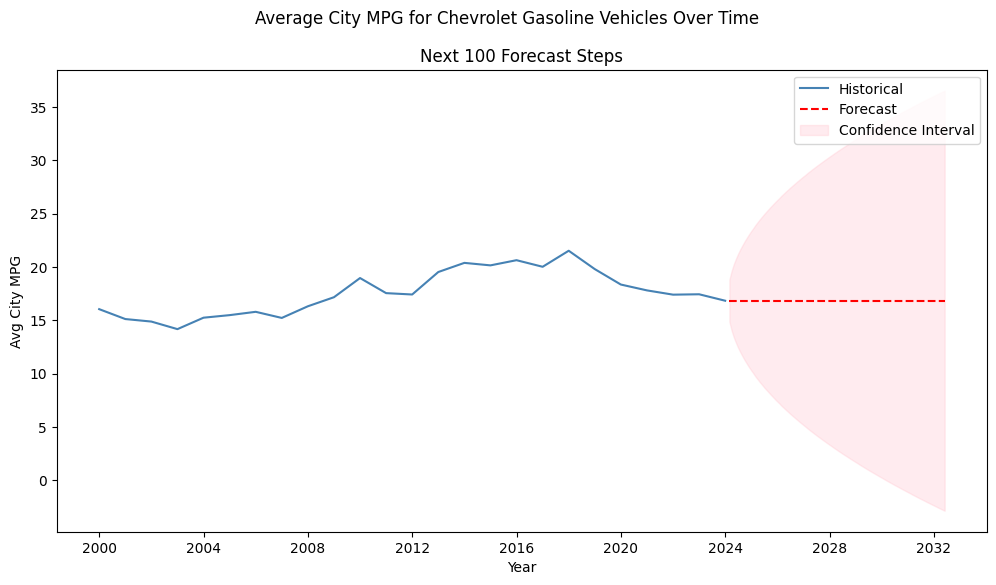

In [142]:
###################TESTING###########################
# Assuming `sorted_gasoline_chevrolet` is your time series data
# sorted_gasoline_chevrolet = pd.Series(...)  # Replace with your actual data

# Fit the SARIMAX model (example with non-seasonal order (1, 1, 0))
model_gchev = ARIMA(sorted_gasoline_chevrolet, order=(0,1,0)).fit()

# Forecast the next 30 periods with confidence intervals
n_periods = 100
forecast = model_gchev.get_forecast(steps=n_periods)
forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int()

# Create a date range for the forecast
last_date = sorted_gasoline_chevrolet.index[-1]
forecast_index = pd.date_range(start=last_date, periods=n_periods + 1, freq='M')[1:]  # Adjust 'M' if needed

# Convert the forecast to a Series
forecast_series = pd.Series(forecast_values.values, index=forecast_index)
conf_int_series = conf_int.set_index(forecast_index)

# Plot the results
plt.figure(figsize=(12, 6))

# Plot historical data
plt.plot(sorted_gasoline_chevrolet.index, sorted_gasoline_chevrolet, color='steelblue', label='Historical')

# Plot forecast data
plt.plot(forecast_series.index, forecast_series, color='red', linestyle='--', label='Forecast')

# Plot confidence intervals
plt.fill_between(conf_int_series.index, conf_int_series.iloc[:, 0], conf_int_series.iloc[:, 1], 
                 color='pink', alpha=0.3, label='Confidence Interval')

plt.suptitle('Average City MPG for Chevrolet Gasoline Vehicles Over Time')
plt.title(f'Next {n_periods} Forecast Steps', fontsize=12)
plt.xlabel('Year')
plt.ylabel('Avg City MPG')
plt.legend()
plt.show()


In [ ]:
#Gasoline Ford
for n in range(1, 31):
    forecast, conf_int = model_gford.predict(n_periods=n, return_conf_int=True)
    # print(f"forecast: {forecast}")
   
    last_element_index = sorted_gasoline_ford.index[-1]  # Get the index of the last ts element
   # print(f"last element index: {last_element_index}")
    
    last_element_value = sorted_gasoline_ford.iloc[-1]   # Get the value of the last ts element
   # print(f"last element value: {last_element_value}")
    
    # Create a Series with the last element and its index
    last_element_series = pd.Series(last_element_value, index=[last_element_index])
    # print(f"last element series: {last_element_series}")


    # Concatenate the two series
    forecast_series = pd.concat([last_element_series, forecast])
   # print(f"Forecast Series: {forecast_series}")

    # Plot train, test, and forecasts with confidence intervals
    plt.figure(figsize=(12, 4))
    plt.plot(sorted_gasoline_ford.index, sorted_gasoline_ford, color='steelblue', label='Historical')
    plt.plot(forecast_series.index, forecast_series, color='red', linestyle='--', label='Forecast')

    # Plot upper and lower confidence intervals
    # plt.fill_between(forecast.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3, label='Confidence Interval')

    plt.suptitle('Average City MPG for Ford Gasoline Vehicles Over Time')
    plt.title(f'{n} Forecast Step(s)', fontsize=12) # subtitle
    plt.xlabel('Year')
    plt.ylabel('Avg City MPG')
    plt.legend()

    # Save the plot as an image file
    plt.savefig(f'../src/static/images/gasolineford/forecast_{n}_steps.png', dpi=300, bbox_inches='tight')

    # Suppress showing the [;pt]
    plt.close()

In [ ]:
#Gasoline Toyota
for n in range(1, 31):
    forecast, conf_int = model_gtoy.predict(n_periods=n, return_conf_int=True)
    # print(f"forecast: {forecast}")
   
    last_element_index = sorted_gasoline_toyota.index[-1]  # Get the index of the last ts element
   # print(f"last element index: {last_element_index}")
    
    last_element_value = sorted_gasoline_toyota.iloc[-1]   # Get the value of the last ts element
   # print(f"last element value: {last_element_value}")
    
    # Create a Series with the last element and its index
    last_element_series = pd.Series(last_element_value, index=[last_element_index])
    # print(f"last element series: {last_element_series}")


    # Concatenate the two series
    forecast_series = pd.concat([last_element_series, forecast])
   # print(f"Forecast Series: {forecast_series}")

    # Plot train, test, and forecasts with confidence intervals
    plt.figure(figsize=(12, 4))
    plt.plot(sorted_gasoline_toyota.index, sorted_gasoline_toyota, color='steelblue', label='Historical')
    plt.plot(forecast_series.index, forecast_series, color='red', linestyle='--', label='Forecast')

    # Plot upper and lower confidence intervals
    # plt.fill_between(forecast.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3, label='Confidence Interval')

    plt.suptitle('Average City MPG for Toyota Gasoline Vehicles Over Time')
    plt.title(f'{n} Forecast Step(s)', fontsize=12) # subtitle
    plt.xlabel('Year')
    plt.ylabel('Avg City MPG')
    plt.legend()

    # Save the plot as an image file
    plt.savefig(f'../src/static/images/gasolinetoyota/forecast_{n}_steps.png', dpi=300, bbox_inches='tight')

    # Suppress showing the [;pt]
    plt.close()

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from joblib import dump, load